# Classification Tutorial
(C) 2018 Dariusz Kajtoch

In this project we will examine tho performance of the most popular machine learning algorithms for classification using weight|height|gender dataset of human population. The objective is to grasp an intuition about how various models work and how we decide if their predictions are correct.

# Table of contents
1. [Data Exploration](#data-exploration)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

# customize graphics
#sns.set_style('white')
sns.set_context('notebook')

# examine and customize further
#print( plt.rcParams )
plt.rcParams['text.usetex'] = True

plt.rcParams['figure.dpi'] = 200.0
plt.rcParams['figure.figsize'] = [10.0,5.0]

# axis
plt.rc( 'ytick', **{'direction':'in', 'right':True})
plt.rc( 'xtick', **{'direction':'in', 'top':True})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.axisbelow'] = True

# grid
plt.rcParams['axes.grid'] = True
plt.rc( 'grid', **{'alpha':1.0, 'color':'0.3', 'linestyle': '--', 'linewidth': 0.5} )

# legend
plt.rc( 'legend', **{'frameon':True, 'fancybox':True, 'framealpha':1.0, 'edgecolor':'1.0'} )

# color pallete
from cycler import cycler
color_palette = plt.get_cmap('tab20').colors

plt.rcParams['axes.prop_cycle'] = cycler( 'color', color_palette )

In [5]:
# import the data
data = pd.read_csv('./data/01_heights_weights_genders.csv', sep=',')

In [16]:
print( data.head() )

  Gender     Height      Weight
0   Male  73.847017  241.893563
1   Male  68.781904  162.310473
2   Male  74.110105  212.740856
3   Male  71.730978  220.042470
4   Male  69.881796  206.349801


# 1. Data Exploration<a name=data-exploration /a>

In [22]:
# correlation between height and weight
data[['Height', 'Weight']].corr( method='pearson' )

Height    Weight
Height  1.000000  0.924756
Weight  0.924756  1.000000

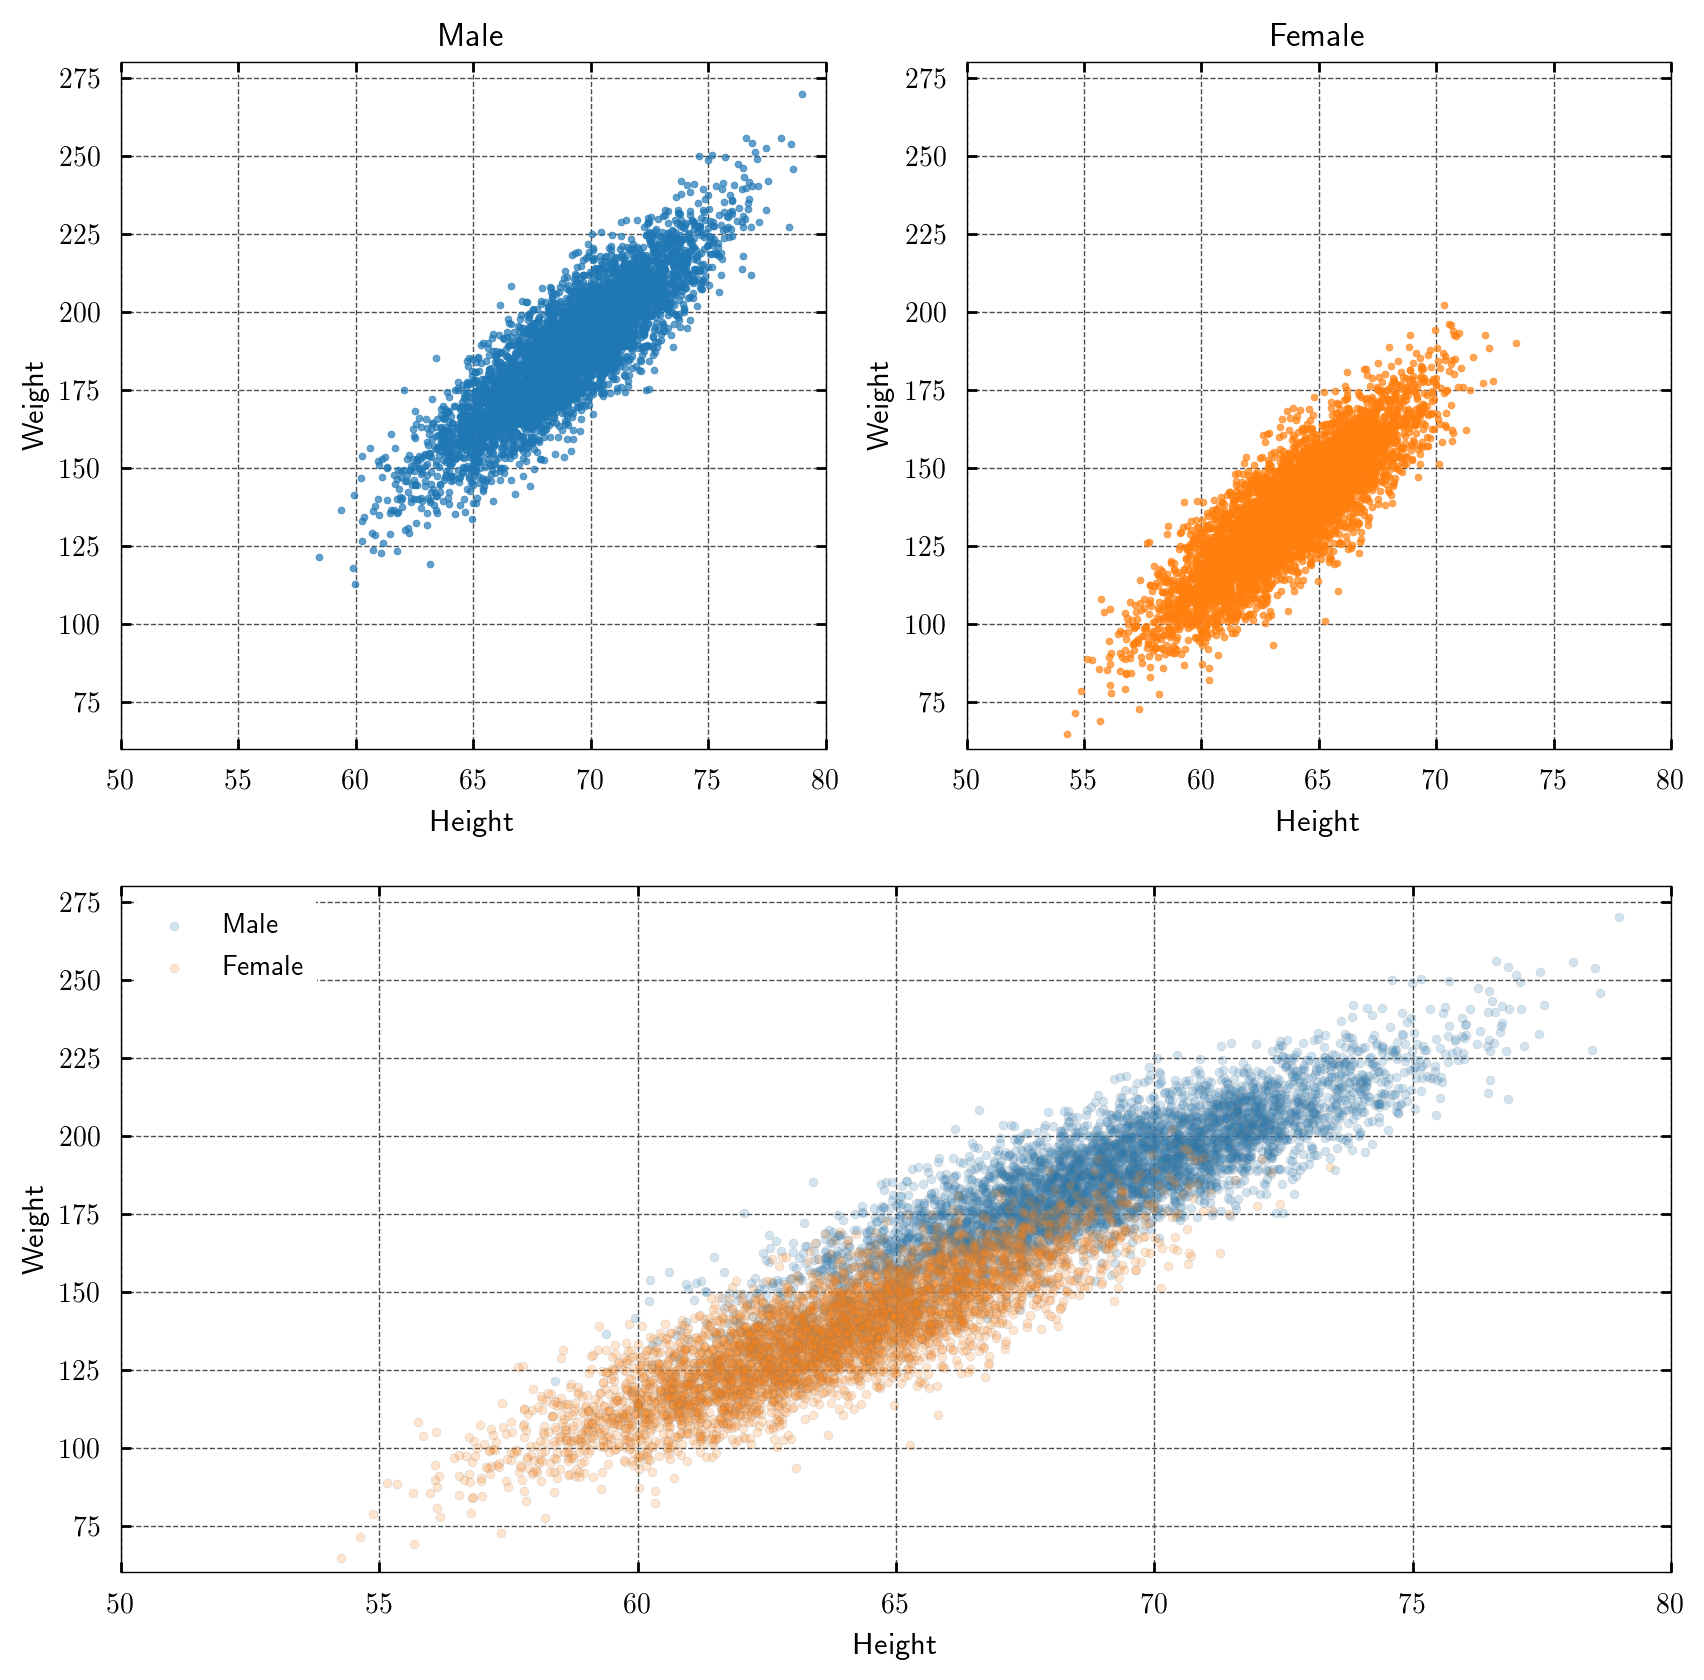

In [9]:
from matplotlib.gridspec import GridSpec

plt.close()

gs = GridSpec( nrows=2, ncols=2, wspace=0.2, hspace=0.2 )

fig = plt.figure( figsize=(10,10) )

ax = [fig.add_subplot( gs[0,0] ),
      fig.add_subplot( gs[0,1] ),
      fig.add_subplot( gs[1,:] )]

for axes in ax:
    axes.set_xlabel('Height')
    axes.set_ylabel('Weight')
    axes.set_xlim(50,80)
    axes.set_ylim(60,280)

# -------------------------- #
# Top row
# -------------------------- #
data_male = data[data['Gender'] == 'Male']
data_female = data[data['Gender'] == 'Female']

ax[0].set_title('Male')
ax[0].scatter( data_male.Height, 
               data_male.Weight,
               c=color_palette[0], # colors
               s=6., # scale
               alpha=0.7, # trasparency
               edgecolor=None,
              )

ax[1].set_title('Female')
ax[1].scatter( data_female.Height, 
               data_female.Weight,
               c=color_palette[2], # colors
               s=6., # scale
               alpha=0.7, # trasparency
               edgecolor=None,
              )

# -------------------- #
# Bootom row
# -------------------- #
for gender, color in {'Male':color_palette[0], 'Female':color_palette[2]}.items():
    ax[2].scatter( data[data.Gender == gender].Height, 
                   data[data.Gender == gender].Weight,
                   c=color, # colors
                   s=10., # scale
                   alpha=0.2, # trasparency
                   edgecolor='0.5',
                   label=gender,
                  )

ax[2].legend()

* We can clearly see that there is a strong positive correlation between `Weight` and `Height` of the person. This is expected. The larger the body size, the heavier the bones and other body parts. 
* We observe that for a given `Height` Males tend to weight more than Females (is it due to muscle weight or fat level?)
* It is a very nice example of a multivariate Gaussian distribution found in nature. For this reason, simple classification models such as LDA, QDA or Naive Bayes may perform very well.  

In [6]:
# Plot decision boundary for a binary classifier
def plot_decision_boundary( ax, data, clf ):
    
    for gender, color in {'Male':color_palette[0], 'Female':color_palette[2]}.items():
        ax.scatter( data[data.Gender == gender].Height, 
                    data[data.Gender == gender].Weight,
                    c=color, # colors
                    s=10., # scale
                    alpha=0.2, # trasparency
                    edgecolor='0.5',
                    label=gender,
                   )

    ax.legend()
    
    X = data[['Height','Weight']].values
    y = data['Gender'].values
    
    # we assume that X has only two features
    xmin = np.min( X[:,0] ) - 1.5
    xmax = np.max( X[:,0] ) + 1.5
    ymin = np.min( X[:,1] ) - 1.5
    ymax = np.max( X[:,1] ) + 1.5
    
    # create a grid of points
    xx, yy = np.meshgrid( np.linspace(xmin,xmax,100),
                          np.linspace(ymin,ymax,100)
                        )
    
    # predict output
    X_predict = np.c_[ xx.ravel(), yy.ravel() ]
    Z = clf.predict( X_predict )
    
    # transform string to integer
    from sklearn.preprocessing import LabelEncoder
    Z = LabelEncoder().fit_transform( Z )
    Z_reshaped = Z.reshape( xx.shape )
    
    # assign color to the output
    from matplotlib import colors
    cmap_back = colors.ListedColormap( [color_palette[3], color_palette[1]] )
    ax.pcolormesh( xx, yy, Z_reshaped, 
                   cmap=cmap_back,
                   edgecolors=None,
                   alpha=0.2
                 )
    
    ax.set_xlabel('Height')
    ax.set_ylabel('Weight')

# 2. Multivariate Gaussian distribution models <a name=mgdm /a>

Multivariate Gaussian distribution models for classification are all based on the assumption, that the probability of getting feature $\mathbf{x}$ given that $y$ belong to a class `c` is given by the multivariate Normal distribution with know mean $\mu_c$ and covariance matrix $\Sigma_c$, i.e.
$$p(\mathbf{x}|y=c) = \mathcal{N}(\mathbf{x}|\pmb{\mu}_c, \Sigma_c).$$
Decision about $y$ is given by the maximum a posteriori estimator:
$$\hat{y} = \text{argmax}_{c}\{p(y=c|\mathbf{x})\},$$
using Bayes rule. 

1. Linear discriminant analaysis (LDA).
    * **Assumption**: $\forall_{c} \Sigma_c = \Sigma$.
2. (Gaussian) Naive Bayes.
    * **Assumption**: $\Sigma_c$ is diagonal (dimensions are uncorrelated).

## 2.2 Quadratic discriminant analysis (QDA) <a name=qda /a>

In [7]:
# prepare variables for modelling
X = data[['Height','Weight']]
y = data['Gender']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y,
                                                     train_size=0.8,
                                                     random_state=0
                                                   ) 

/opt/intel/intelpython3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()
qda.fit( X_train, y_train )

print( 'QDA train score: %.3f' % qda.score( X_train, y_train ) )
print( 'QDA test score: %.3f' % qda.score( X_test, y_test ) )

QDA train score: 0.918
QDA test score: 0.921


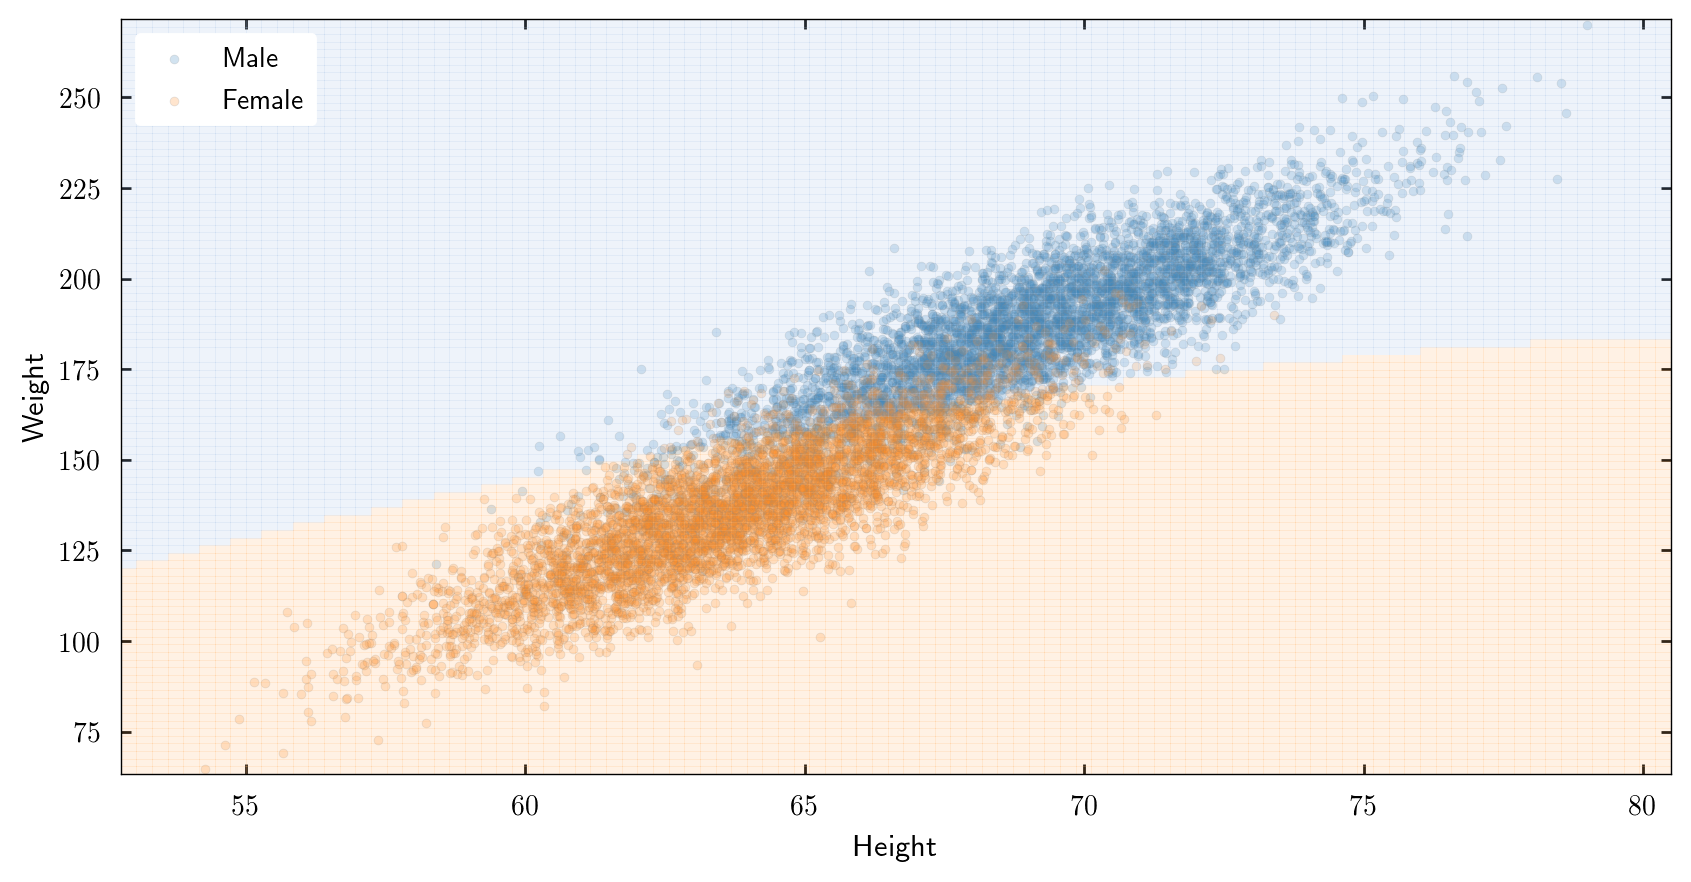

In [56]:
plt.close()

fig, ax = plt.subplots()

plot_decision_boundary( ax, data, qda )

In [77]:
# K-fold validation
from sklearn.model_selection import KFold

kf = KFold( n_splits=6 )

for train_index, test_index in kf.split( X ):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    qda.fit( X_train, y_train )
    print( 'QDA test score: %.3f' % qda.score( X_test, y_test ) ) 

QDA test score: 0.893
QDA test score: 0.881
QDA test score: 0.900
QDA test score: 0.890
QDA test score: 0.891
QDA test score: 0.882


## 2.3 Linear discriminant analysis (LDA) <a name=lda /a>

In [49]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit( X_train, y_train )

print( 'LDA train score: %.3f' % lda.score( X_train, y_train ) )
print( 'LDA test score: %.3f' % lda.score( X_test, y_test ) )

LDA train score: 0.919
LDA test score: 0.922


In [79]:
# K-fold validation
from sklearn.model_selection import KFold

kf = KFold( n_splits=6 )

for train_index, test_index in kf.split( X ):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lda.fit( X_train, y_train )
    print( 'LDA test score: %.3f' % lda.score( X_test, y_test ) ) 

QDA test score: 0.891
QDA test score: 0.879
QDA test score: 0.899
QDA test score: 0.891
QDA test score: 0.894
QDA test score: 0.883


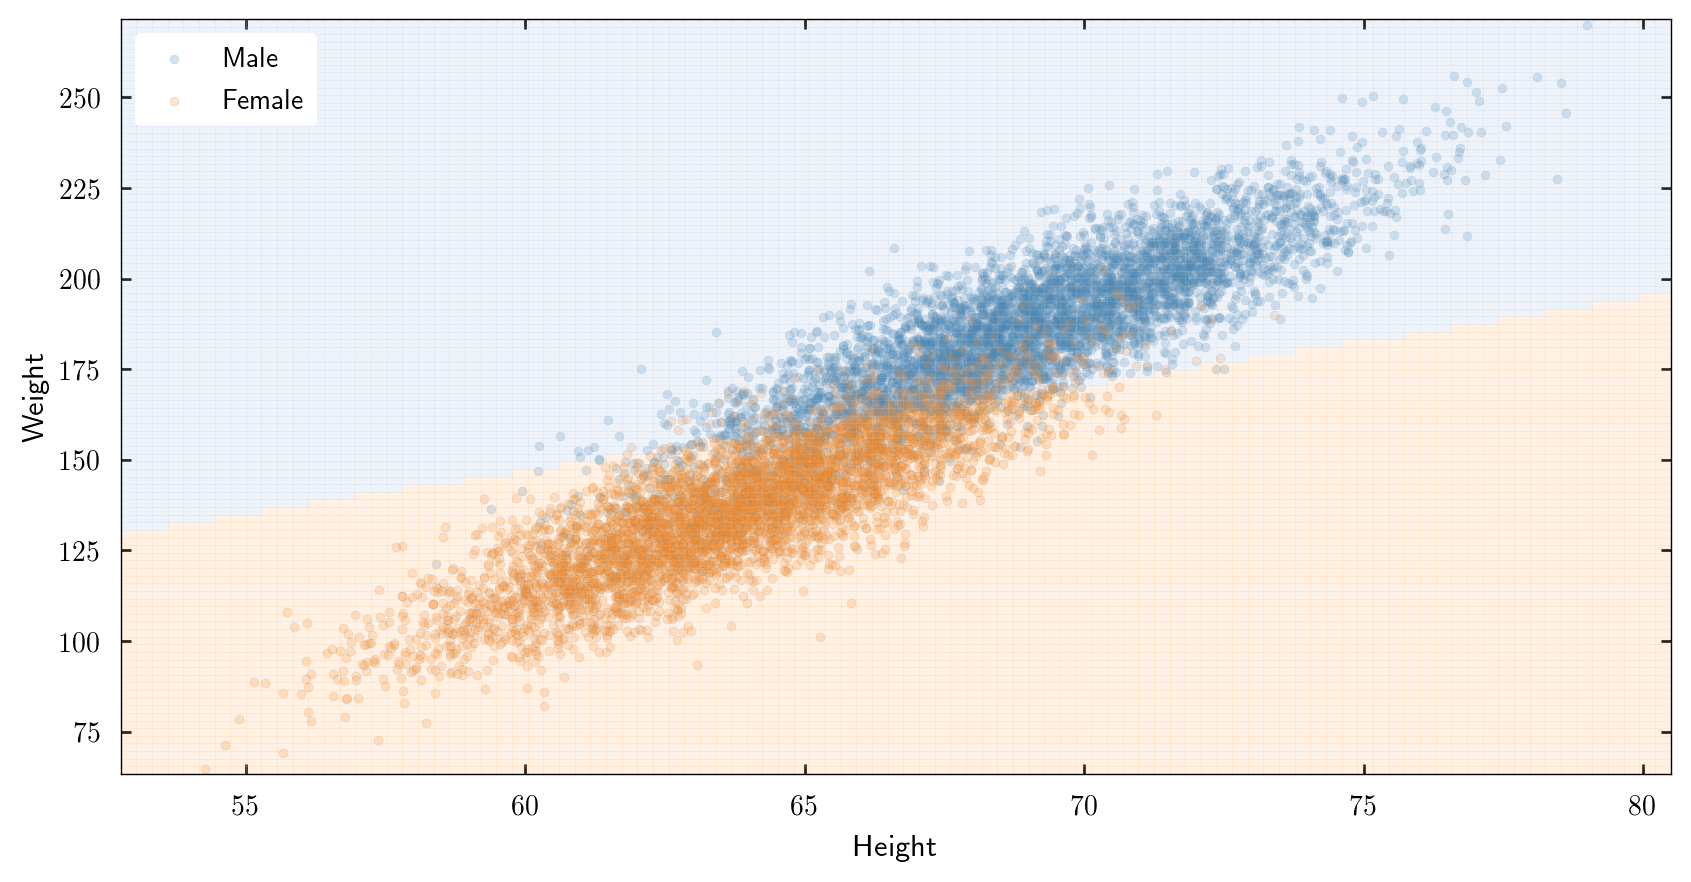

In [57]:
plt.close()

fig, ax = plt.subplots()

plot_decision_boundary( ax, data, lda )

## 2.4 Gaussian Naive Bayes <a name=gnb /a>

In [51]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit( X_train, y_train )

print( 'Naive Bayes train score: %.3f' % gnb.score( X_train, y_train ) )
print( 'Naive Bayes test score: %.3f' % gnb.score( X_test, y_test ) )

Naive Bayes train score: 0.888
Naive Bayes test score: 0.883


In [80]:
# K-fold validation
from sklearn.model_selection import KFold

kf = KFold( n_splits=6 )

for train_index, test_index in kf.split( X ):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    gnb.fit( X_train, y_train )
    print( 'Naive Bayes test score: %.3f' % gnb.score( X_test, y_test ) ) 

Naive Bayes test score: 0.867
Naive Bayes test score: 0.855
Naive Bayes test score: 0.875
Naive Bayes test score: 0.874
Naive Bayes test score: 0.866
Naive Bayes test score: 0.867


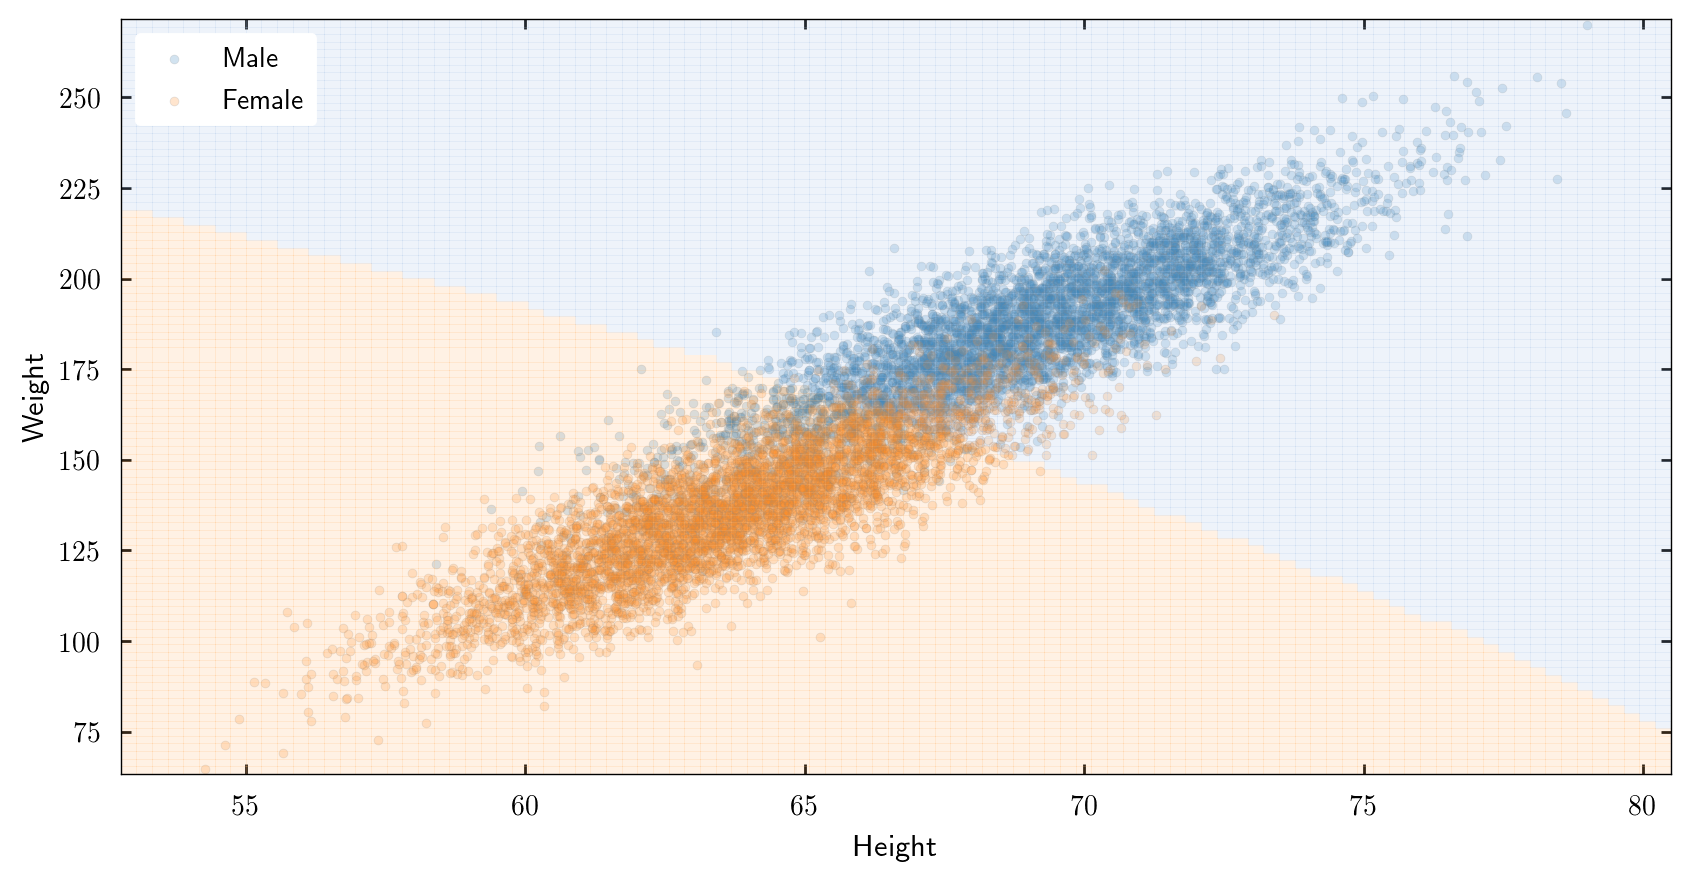

In [58]:
plt.close()

fig, ax = plt.subplots()

plot_decision_boundary( ax, data, gnb )

## 2.5 ROC and Precision-recall comparison <a name=roc /a>

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder

y_true = LabelEncoder().fit_transform( y_test )

print( 'LDA AUC score: %.5f' % roc_auc_score( y_true, lda.predict_proba( X_test )[:,1] ) )
print( 'QDA AUC score: %.5f' % roc_auc_score( y_true, qda.predict_proba( X_test )[:,1] ) )
print( 'Naive Bayes AUC score: %.5f' % roc_auc_score( y_true, gnb.predict_proba( X_test )[:,1] ) )

LDA AUC score: 0.97099
QDA AUC score: 0.97099
Naive Bayes AUC score: 0.95250


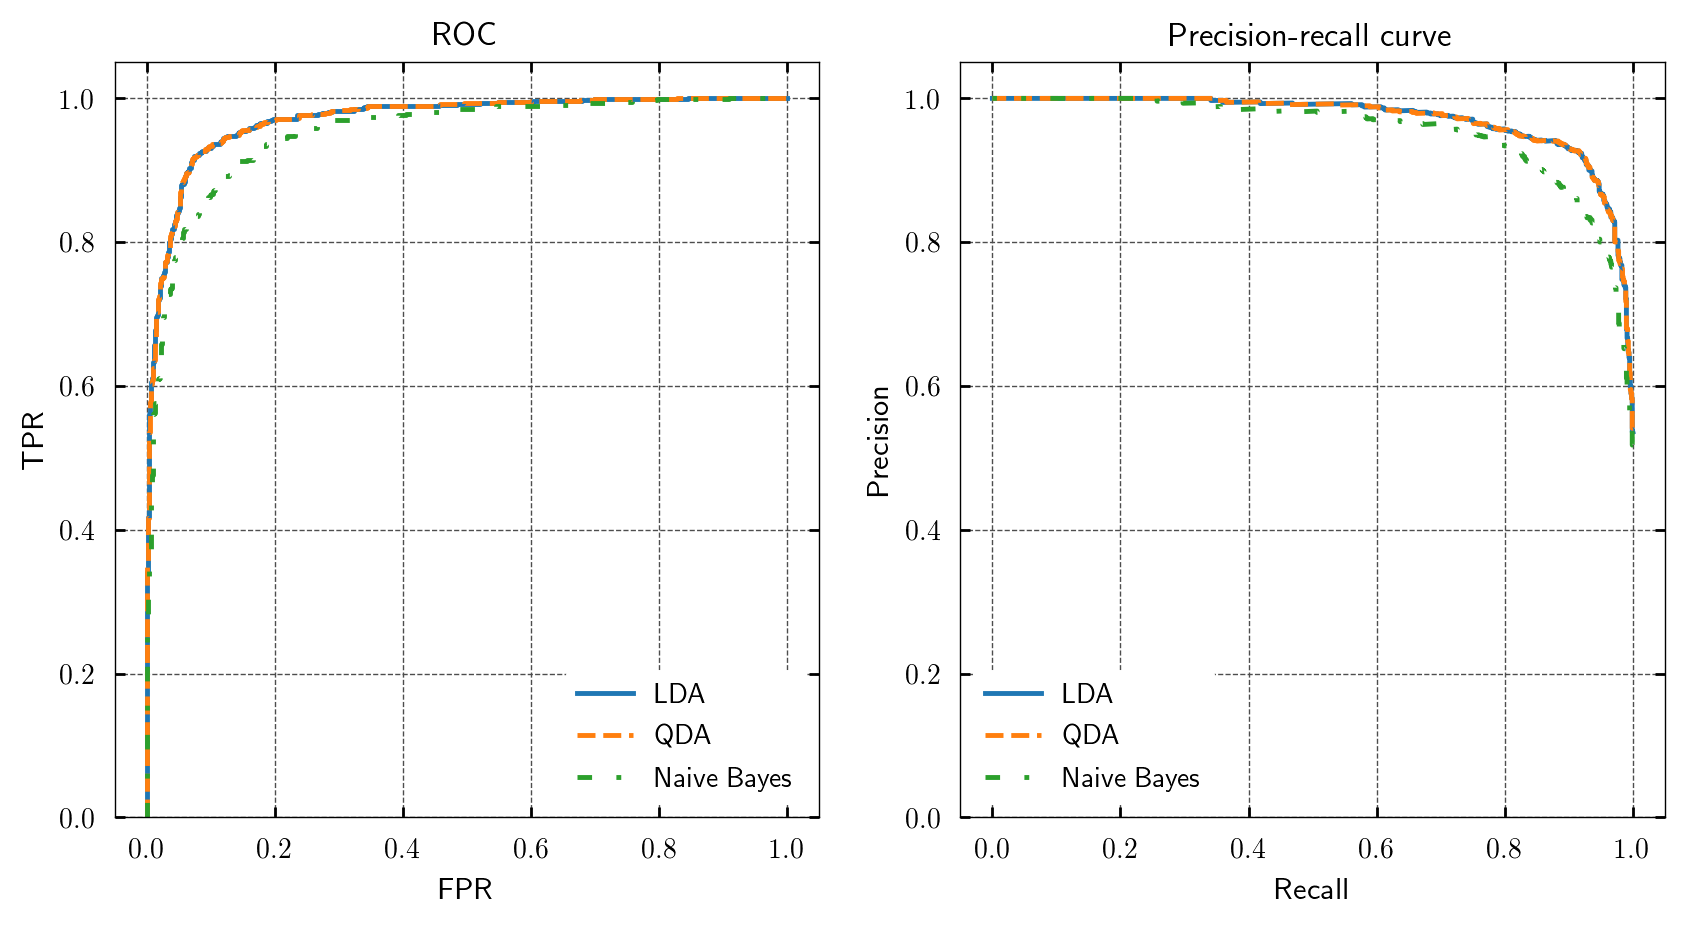

In [40]:
plt.close()

fig, ax = plt.subplots( nrows=1, 
                        ncols=2,
                        gridspec_kw={'wspace':0.2, 'hspace':0.2}  
                       )

ax[0].set_xlabel('FPR')
ax[0].set_ylabel('TPR')
ax[0].set_title('ROC')

ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-recall curve')

# LDA 
fpr, tpr, thresholds = roc_curve( y_true, lda.predict_proba( X_test )[:,1] )
ax[0].plot( fpr, tpr, c=color_palette[0], label='LDA' )
precision, recall, thresholds = precision_recall_curve( y_true, lda.predict_proba( X_test )[:,1] )
ax[1].plot( recall, precision, c=color_palette[0], label='LDA' )

# QDA 
fpr, tpr, thresholds = roc_curve( y_true, qda.predict_proba( X_test )[:,1] )
ax[0].plot( fpr, tpr, c=color_palette[2], linestyle='dashed', label='QDA' )
precision, recall, thresholds = precision_recall_curve( y_true, qda.predict_proba( X_test )[:,1] )
ax[1].plot( recall, precision, c=color_palette[2], linestyle='dashed', label='QDA' )

# GNB 
fpr, tpr, thresholds = roc_curve( y_true, gnb.predict_proba( X_test )[:,1] )
ax[0].plot( fpr, tpr, c=color_palette[4], linestyle=(0,(3,5,1,5)), label='Naive Bayes' )
precision, recall, thresholds = precision_recall_curve( y_true, gnb.predict_proba( X_test )[:,1] )
ax[1].plot( recall, precision, c=color_palette[4], linestyle=(0,(3,5,1,5)), label='Naive Bayes' )

for axes in ax:
    axes.legend()
    axes.set_xlim(-0.05, 1.05)
    axes.set_ylim(0, 1.05)

## 2.6 Fixing Naive Bayes <a name=fixing_naive /a>
Naive Bayes assumes there is no correlation between dimensions, which is not true as can be seen in the first figure. We can fix it by rotating the variables and creating new one which will be uncorrelated.

In [52]:
# new variables
w, v = np.linalg.eigh( X_train.cov().values )

In [64]:
# linear transformation of the data
new_X = pd.DataFrame()
new_X['1'] = X_train['Height'] * v[0,0] + X_train['Weight'] * v[0,1]
new_X['2'] = X_train['Height'] * v[1,0] + X_train['Weight'] * v[1,1]

new_X_test = pd.DataFrame()
new_X_test['1'] = X_test['Height'] * v[0,0] + X_test['Weight'] * v[0,1]
new_X_test['2'] = X_test['Height'] * v[1,0] + X_test['Weight'] * v[1,1]

In [65]:
gnb = GaussianNB()

gnb.fit( new_X, y_train )

print( 'Naive Bayes train score: %.3f' % gnb.score( new_X, y_train ) )
print( 'Naive Bayes test score: %.3f' % gnb.score( new_X_test, y_test ) )

Naive Bayes train score: 0.912
Naive Bayes test score: 0.915


# 3. K-Nearest Neighbors <a name=knn /a>

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors':np.arange(1,100,4), 
              'p':[1,2]
             }

knc = KNeighborsClassifier()

clf = GridSearchCV( estimator=knc,
                    param_grid=param_grid,
                    cv=5,
                    verbose=True
                  )

clf.fit( X_train, y_train )

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  5,  9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65,
       69, 73, 77, 81, 85, 89, 93, 97]), 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

Text(0.5,1,'5-fold cross-Validation')

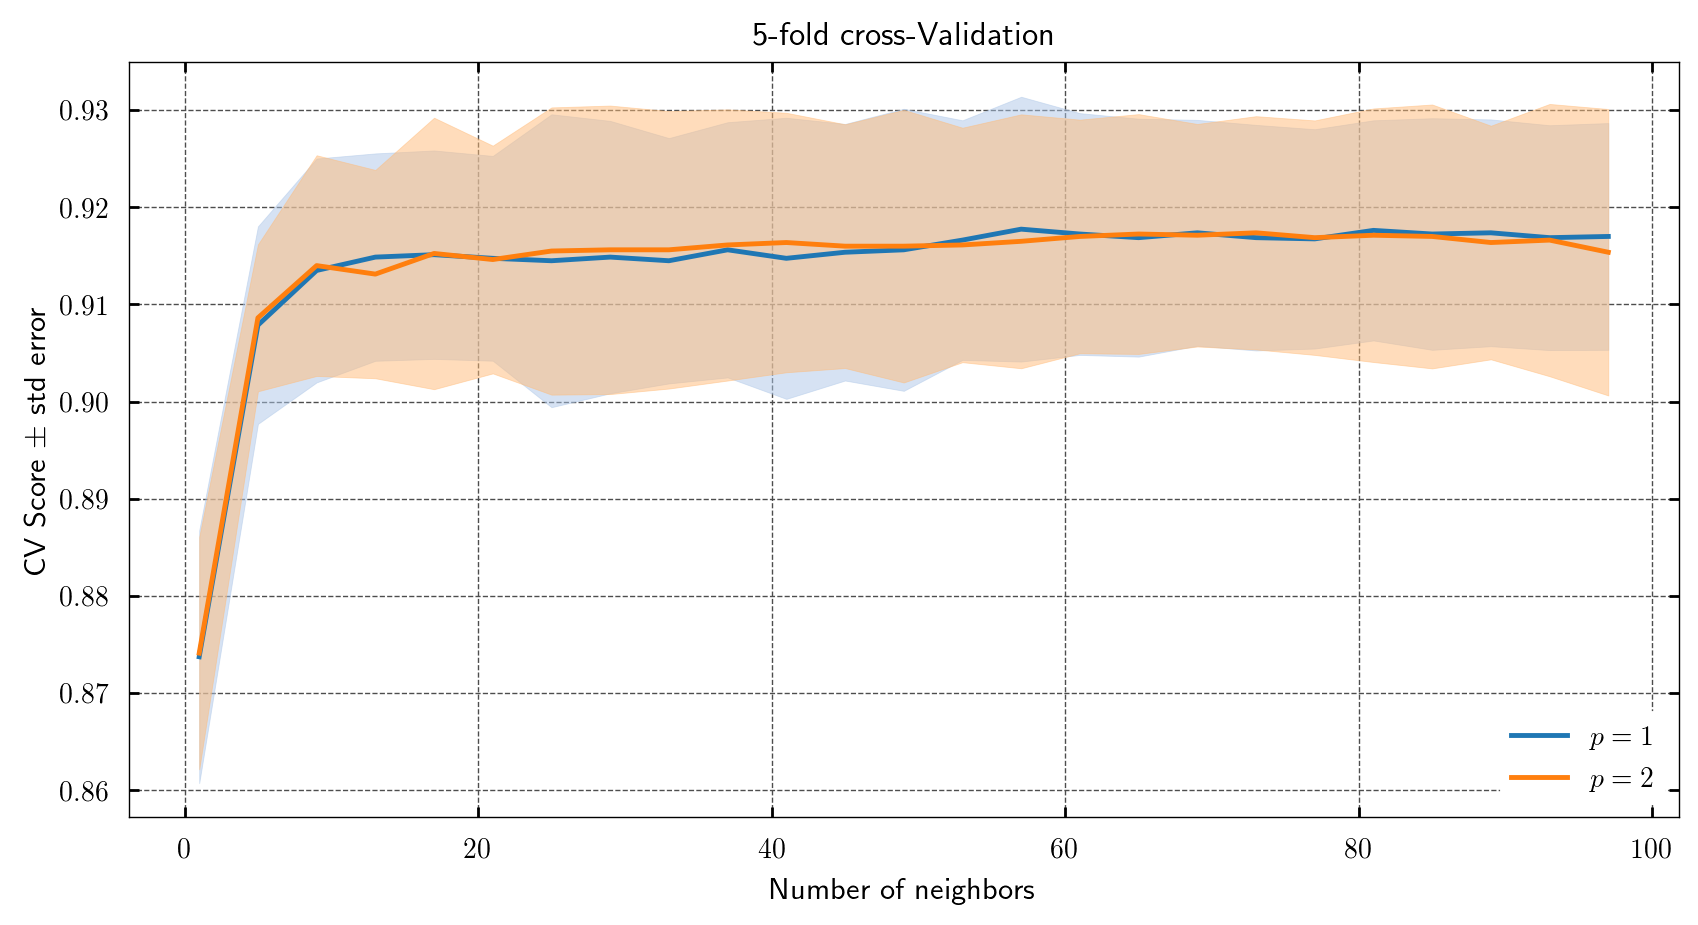

In [43]:
plot_n_neighbors = np.array( [clf.cv_results_['params'][i]['n_neighbors'] for i in range(0, 50)] )
plot_p = np.array( [clf.cv_results_['params'][i]['p'] for i in range(0, 50)] )
plot_mean = clf.cv_results_['mean_test_score']
plot_std = clf.cv_results_['std_test_score']

plt.close()

fig, ax = plt.subplots()

# Manhattan metric
ax.plot( plot_n_neighbors[::2], plot_mean[::2],
         c=color_palette[0],
         label='$p=1$'
       )
ax.fill_between( plot_n_neighbors[::2], plot_mean[::2]-2.*plot_std[::2], plot_mean[::2]+2.*plot_std[::2],
                 color=color_palette[1],
                 alpha=0.5
               )

# Euclidean metric
ax.plot( plot_n_neighbors[1::2], plot_mean[1::2],
         c=color_palette[2],
         label='$p=2$'
       )
ax.fill_between( plot_n_neighbors[1::2], plot_mean[1::2]-2.*plot_std[1::2], plot_mean[1::2]+2.*plot_std[1::2],
                 color=color_palette[3],
                 alpha=0.5
               )

ax.legend(loc='lower right')
ax.set_xlabel('Number of neighbors')
ax.set_ylabel('CV Score $\pm$ std error')
ax.set_title('5-fold cross-Validation')

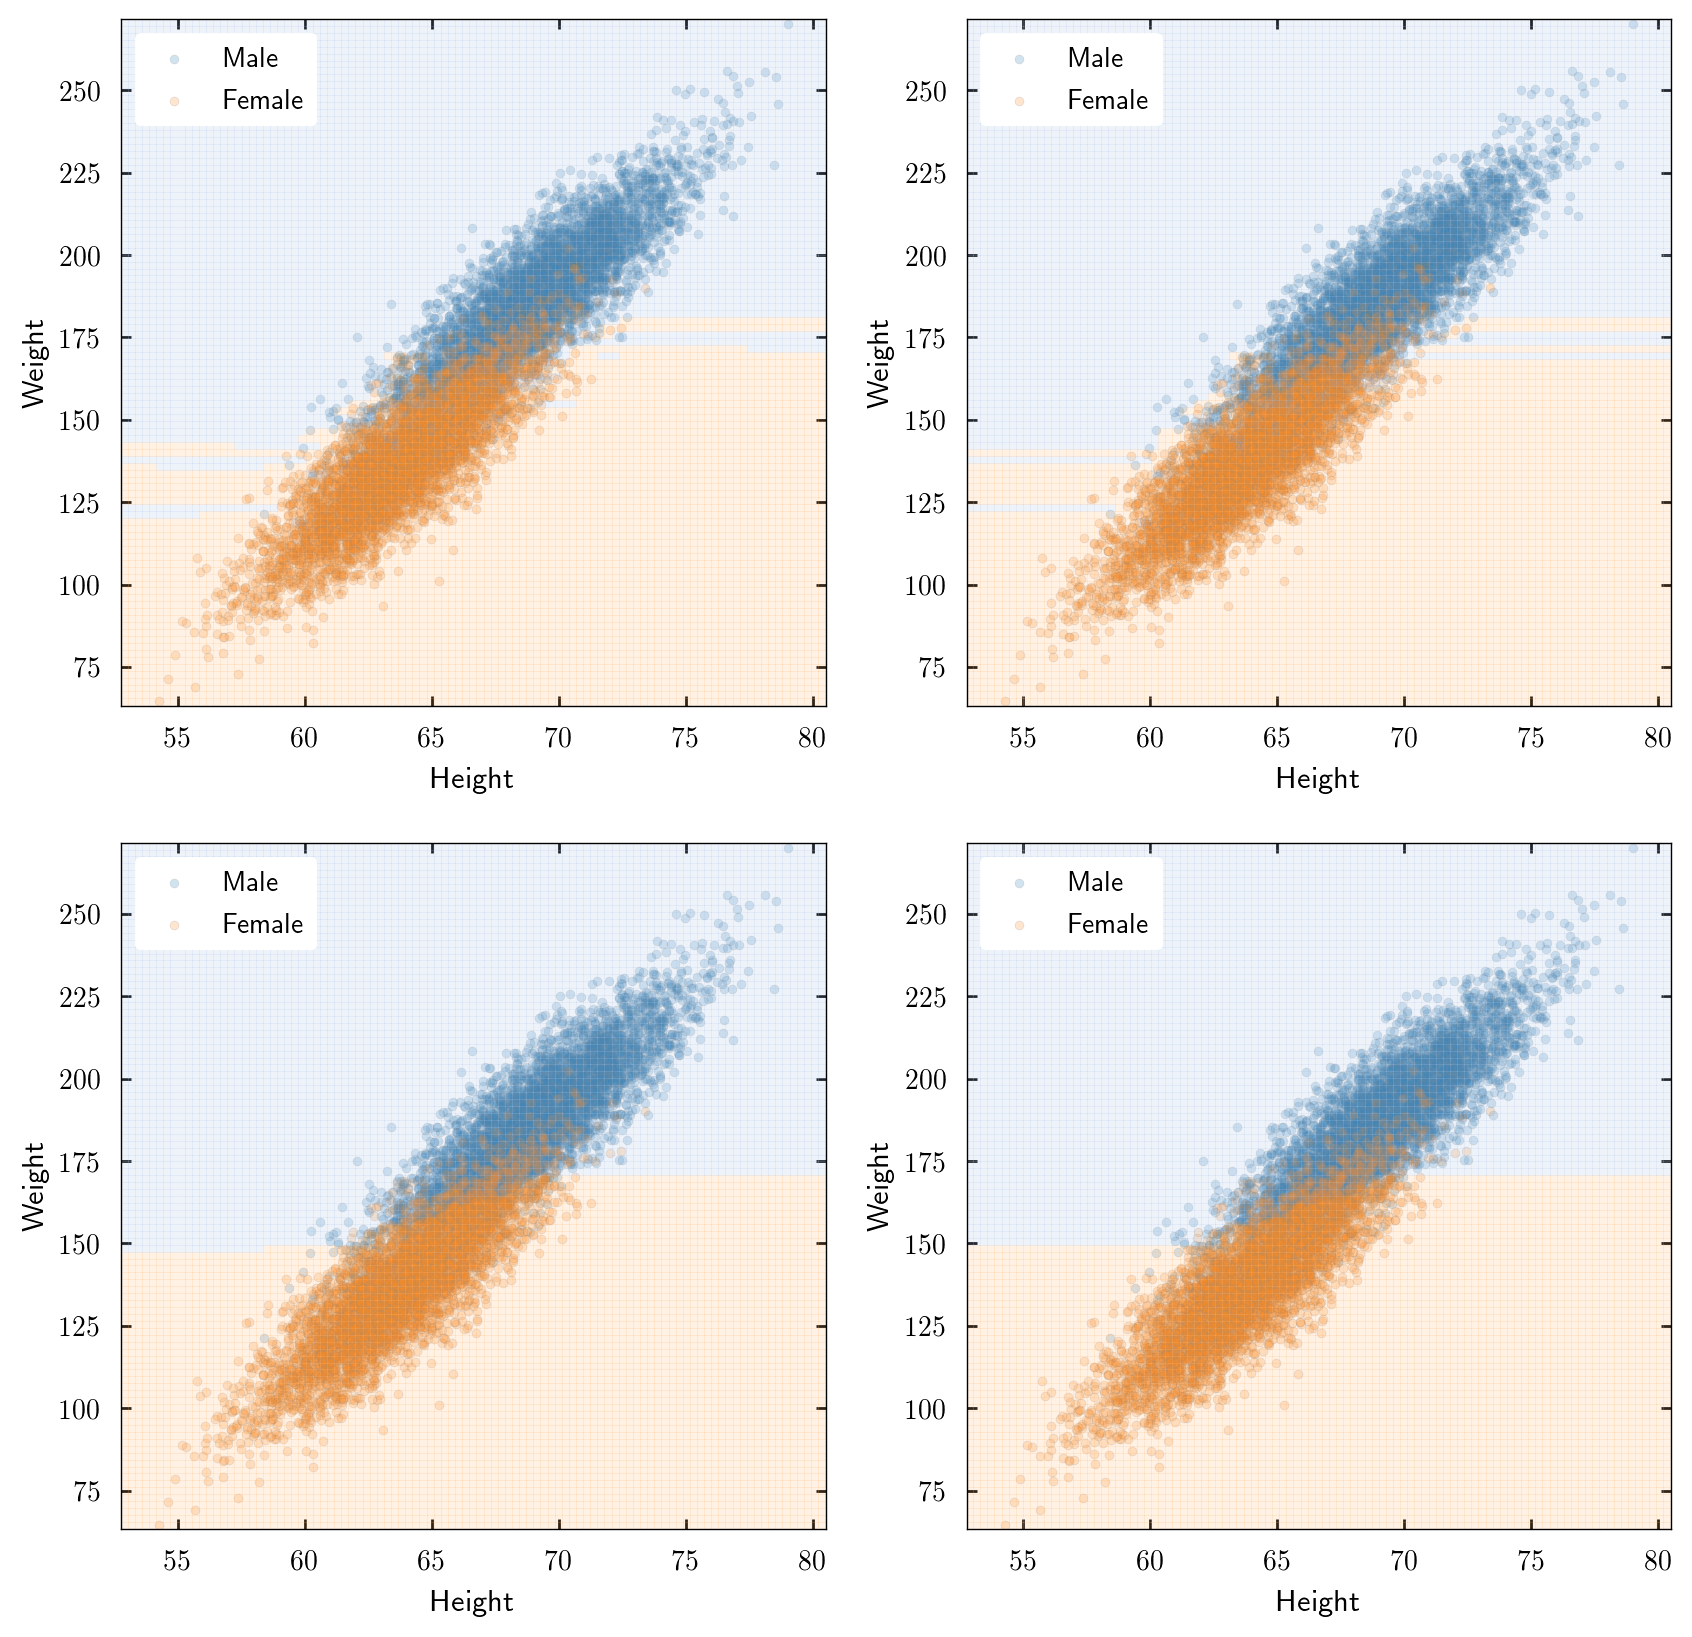

In [61]:
from sklearn.neighbors import KNeighborsClassifier

plt.close()

fig, ax = plt.subplots( nrows=2, ncols=2, figsize=(10,10) )

knc = KNeighborsClassifier(n_neighbors=1, p=2)
knc.fit( X_train, y_train )
plot_decision_boundary( ax[0,0], data, knc )

knc = KNeighborsClassifier(n_neighbors=1, p=1)
knc.fit( X_train, y_train )
plot_decision_boundary( ax[0,1], data, knc )

knc = KNeighborsClassifier(n_neighbors=20, p=2)
knc.fit( X_train, y_train )
plot_decision_boundary( ax[1,0], data, knc )

knc = KNeighborsClassifier(n_neighbors=20, p=1)
knc.fit( X_train, y_train )
plot_decision_boundary( ax[1,1], data, knc )

# 4. Logistic Regression

In [78]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression automatically put numerical labels 
lr = LogisticRegression()
param_grid = {'penalty':['l1','l2'],
              'C':np.linspace(0.001,10,10)
             }

clf = GridSearchCV( estimator=lr,
                    param_grid=param_grid,
                    cv=5,
                    verbose=True
                  )

clf.fit( X_train, y_train )

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   56.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([1.000e-03, 1.112e+00, 2.223e+00, 3.334e+00, 4.445e+00, 5.556e+00,
       6.667e+00, 7.778e+00, 8.889e+00, 1.000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

Text(0.5,1,'5-fold cross-Validation')

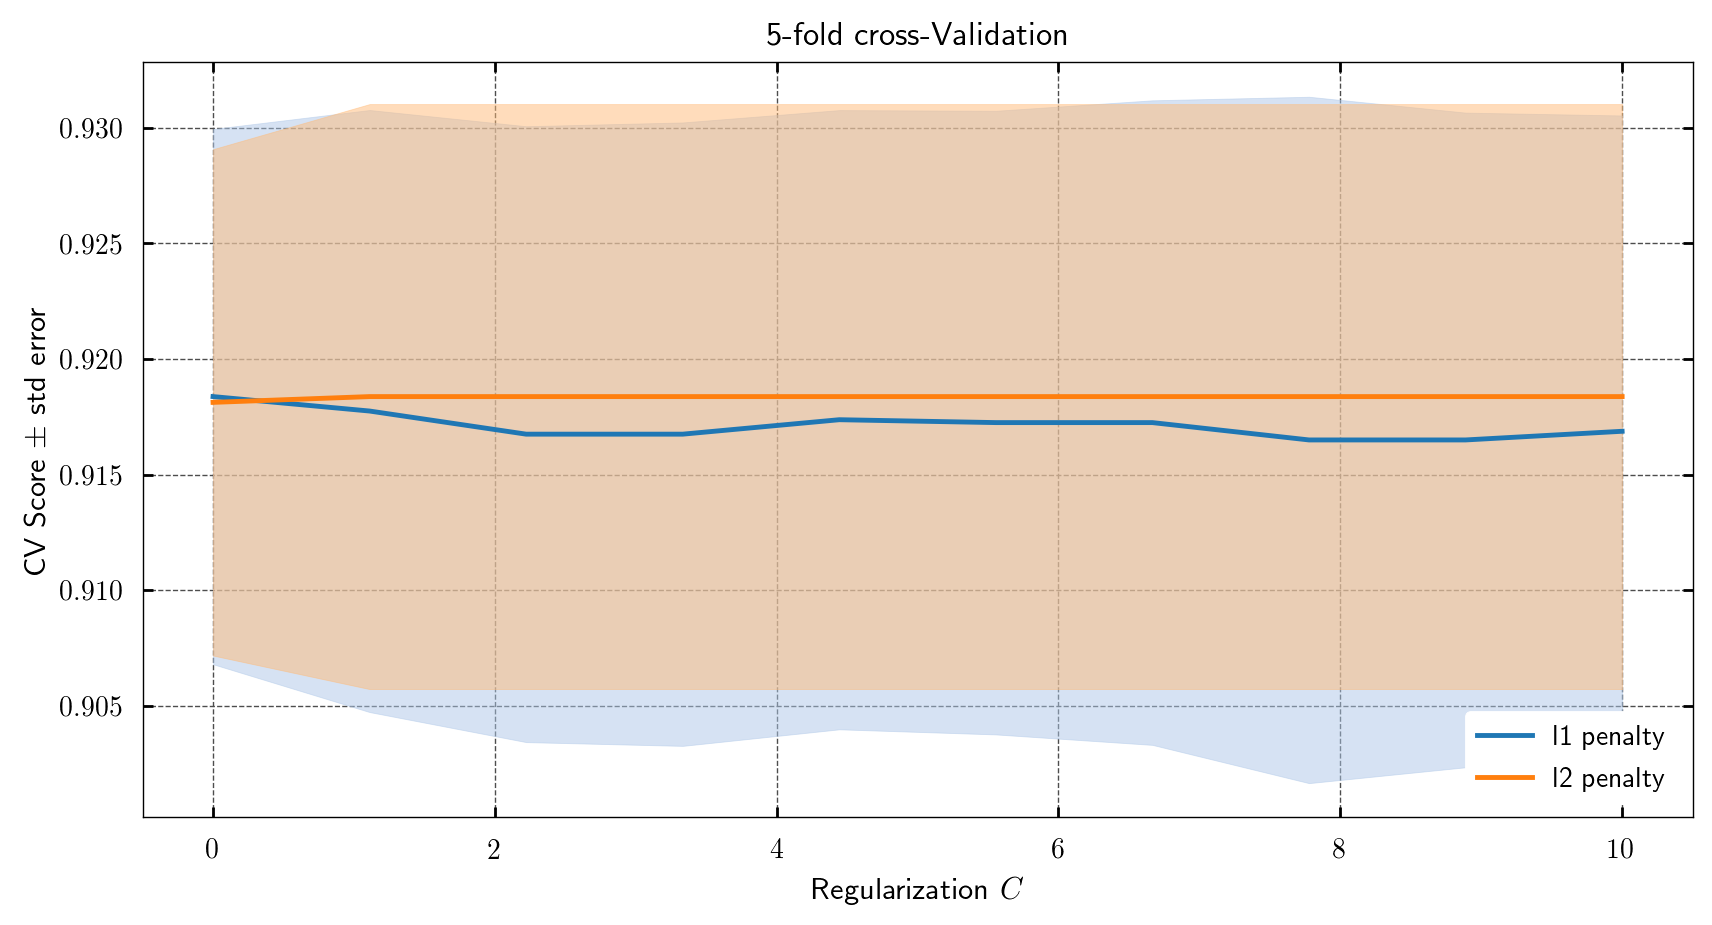

In [79]:
plot_mean = clf.cv_results_['mean_test_score']
plot_std  = clf.cv_results_['std_test_score']
C_tab     = np.array( [clf.cv_results_['params'][i]['C'] for i in range(0, len(plot_mean))] )

plt.close()

fig, ax = plt.subplots()

# Manhattan metric
ax.plot( C_tab[::2], plot_mean[::2],
         c=color_palette[0],
         label='l1 penalty'
       )
ax.fill_between( C_tab[::2], plot_mean[::2]-2.*plot_std[::2], plot_mean[::2]+2.*plot_std[::2],
                 color=color_palette[1],
                 alpha=0.5
               )

# Euclidean metric
ax.plot( C_tab[1::2], plot_mean[1::2],
         c=color_palette[2],
         label='l2 penalty'
       )
ax.fill_between( C_tab[1::2], plot_mean[1::2]-2.*plot_std[1::2], plot_mean[1::2]+2.*plot_std[1::2],
                 color=color_palette[3],
                 alpha=0.5
               )

ax.legend(loc='lower right')
ax.set_xlabel('Regularization $C$')
ax.set_ylabel('CV Score $\pm$ std error')
ax.set_title('5-fold cross-Validation')

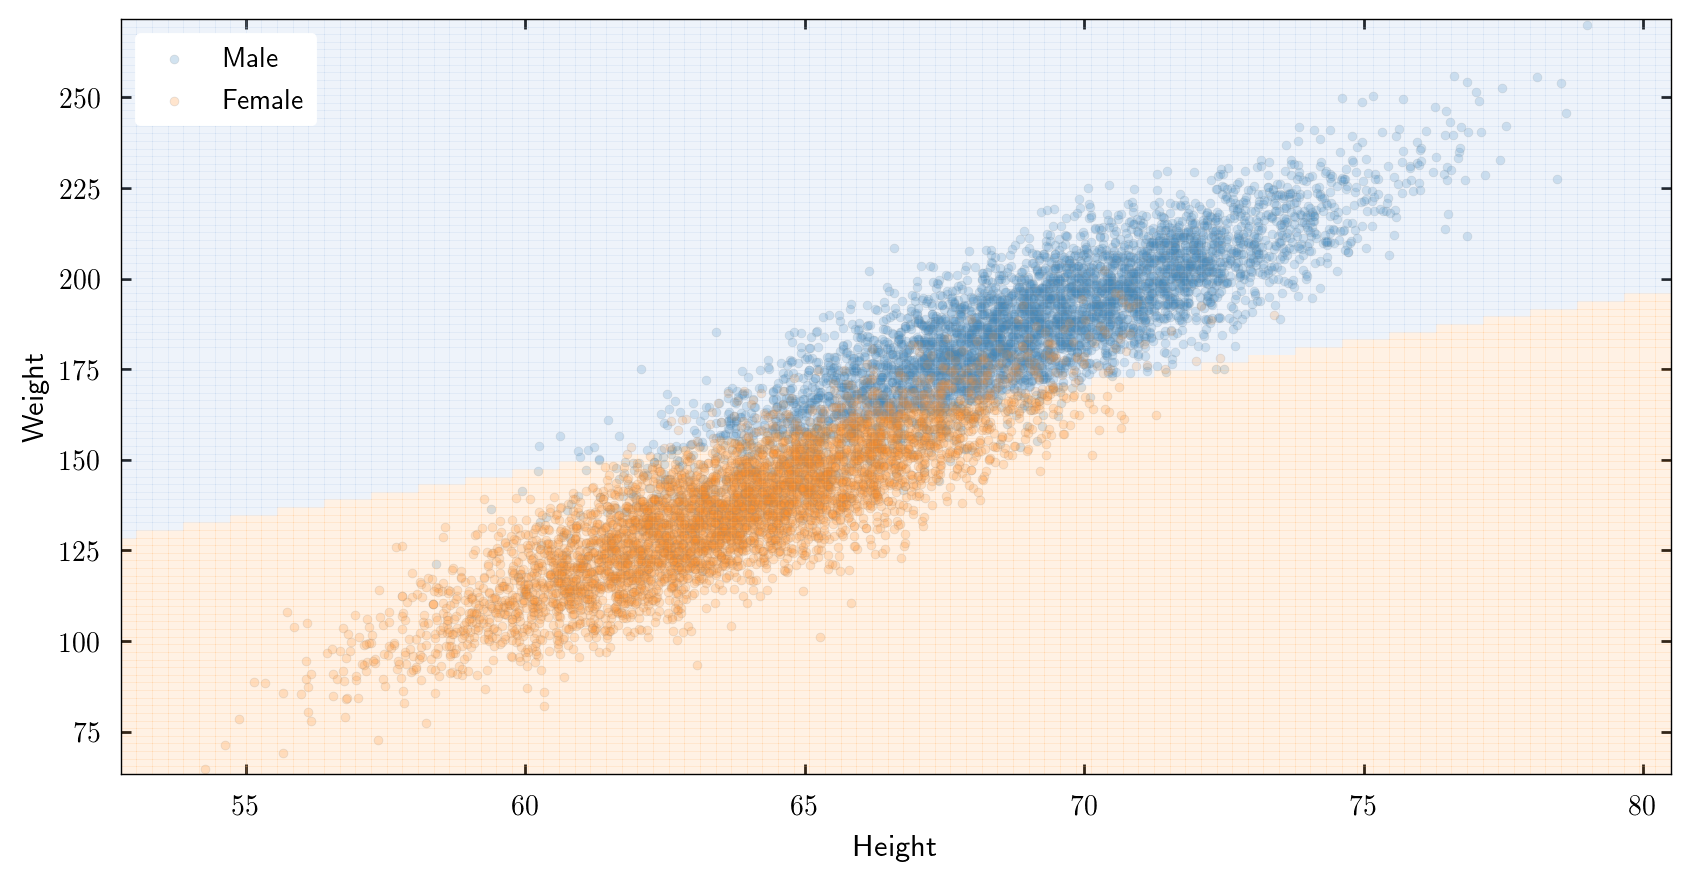

In [62]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression automatically put numerical labels 
lr = LogisticRegression()
lr.fit( X_train, y_train )

plt.close()

fig, ax = plt.subplots()

plot_decision_boundary( ax, data, lr )

# 5. Support Vector Machine (SVM)
[Practical guide to SVMs](https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf)

Support vector machine is trying to find a separating hyperplane using \textit{maximum margin rule}.

### The model
We have the training data $\{\mathbf{x}_i, y_i \}_{i=1}^{N}$, where $\mathbf{x}_i \in R^{p}$ and $y_i \in \{-1,1\}$.

Define a hyperplane
$$H_{\mathbf{w}} := \{\mathbf{x} \in R^{p}: f_{\mathbf{w}}(\mathbf{x}) = \mathbf{w}^{T} \cdot \mathbf{x} + w_0 = 0 \},$$
where $||\mathbf{w}|| = 1$ is normalized to 1. 

### Decision rule
$$G(\mathbf{x}) = \text{sign}( \mathbf{w}^{T} \cdot \mathbf{x} + w_0).$$

### Minimization problem
$$\min\limits_{\mathbf{w}, w_0, \xi} \frac{1}{2}||\mathbf{w}||^2 + C \sum\limits_{i=1}^{N}\xi_i,$$
subject to constraints
$$\forall_i\ \ \ y_i ( \mathbf{w}^T \cdot \phi(\mathbf{x}_i) + w_0) \geqslant 1-\xi_i,$$
$$\forall_i\ \ \ \xi_i \geqslant 0,$$
with some transformation function $\phi: R^{p} \to R^{q}$, which define the *kernel* function:
$$K(\mathbf{x}_i,\mathbf{x}_j) = \phi^{T}(\mathbf{x}_i)\cdot \phi(\mathbf{x}_j).$$

$C = \infty$ (hard margin)

$C >0$ (soft margin)

### General solution
One can show the exact form of $\phi$ is not required for the solution, since everyting can be expressed in therm sof the kernel function, i.e.
$$f(\mathbf{x}) = \sum\limits_{i=1}^{N}\alpha_i y_i K(\mathbf{x},\mathbf{x}_i) + w_0$$

## 5.1 Linear Kernel

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svc = SVC()

param_grid = {'kernel':['linear'],
              'C':np.linspace(0.0001,100.,5)
             }

clf = GridSearchCV( estimator=svc,
                    param_grid=param_grid,
                    cv=5,
                    verbose=True
                  )

clf.fit( X_train, y_train )

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
plot_mean = clf.cv_results_['mean_test_score']
plot_std  = clf.cv_results_['std_test_score']
C_tab     = np.array( [clf.cv_results_['params'][i]['C'] for i in range(0, len(plot_mean))] )

plt.close()

fig, ax = plt.subplots()

ax.plot( C_tab, plot_mean,
         c=color_palette[0]
       )
ax.fill_between( C_tab, plot_mean-2.*plot_std, plot_mean+2.*plot_std,
                 color=color_palette[1],
                 alpha=0.5
               )

ax.set_xlabel('Regularization $C$')
ax.set_ylabel('CV Score $\pm$ std error')
ax.set_title('5-fold cross-Validation | Linear kernel')

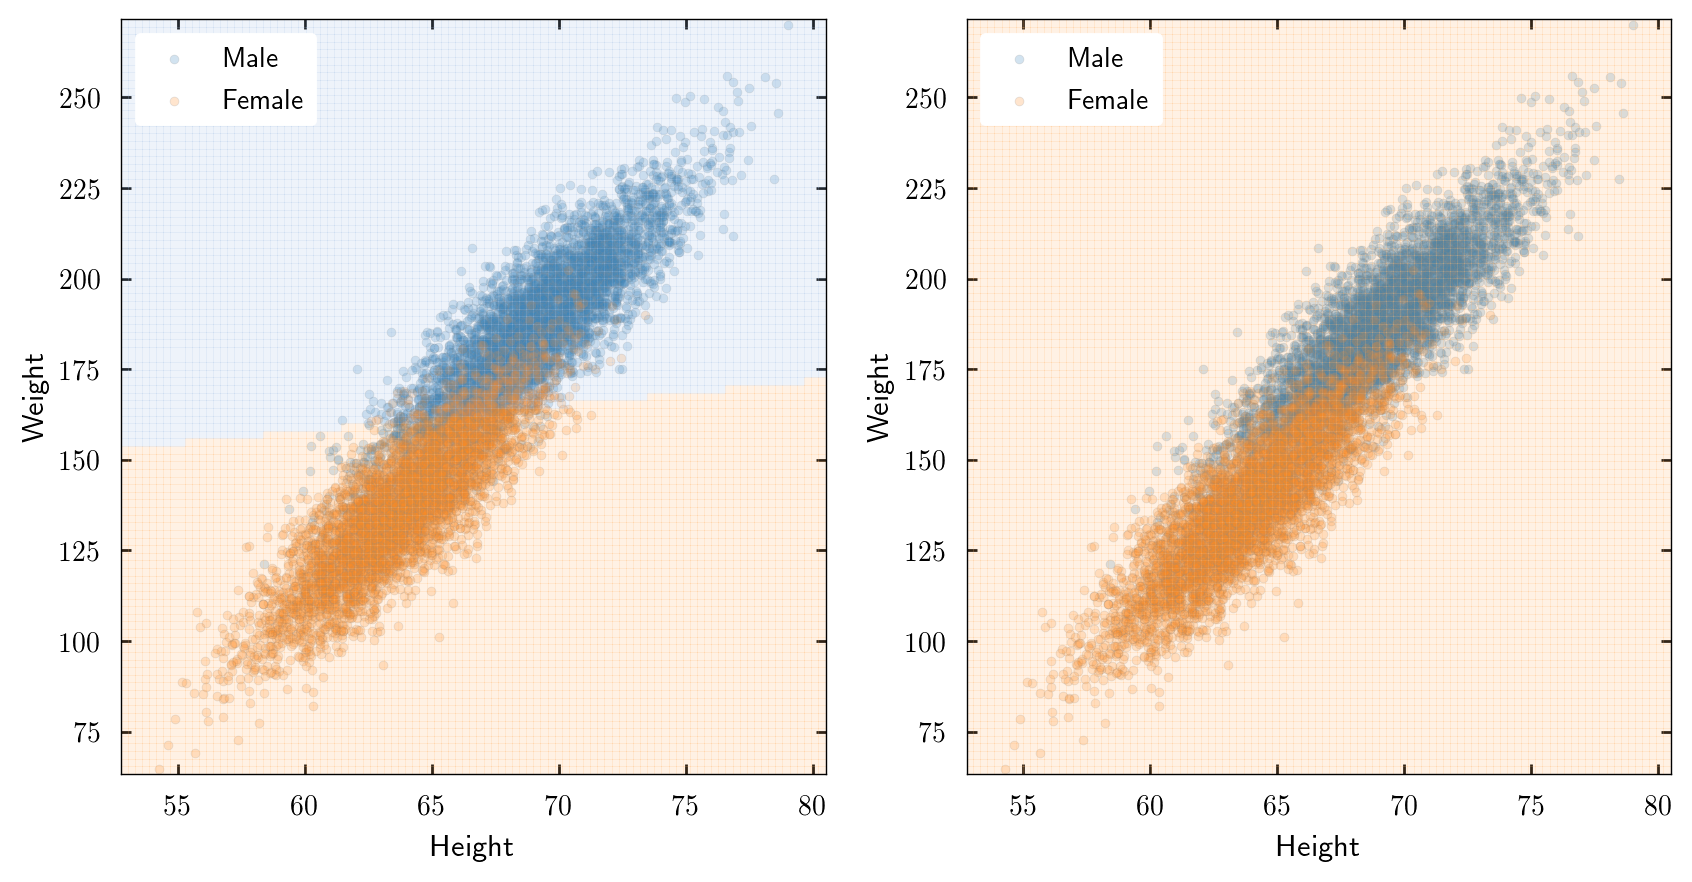

In [70]:
from sklearn.svm import SVC

plt.close()

fig, ax = plt.subplots( nrows=1, ncols=2 )

svc = SVC(kernel='linear', C=0.0001)
svc.fit( X_train, y_train )
plot_decision_boundary( ax[0], data, svc )

svc = SVC(kernel='linear', C=0.1)
svc.fit( X_train, y_train )
plot_decision_boundary( ax[1], data, svc )

## 5.2 RBF Kernel

In [ ]:
svc = SVC()

param_grid = {'kernel':['rbf'],
              'C':[0.0001, 100],
              'gamma':np.linspace(0.0001,100.,5)
             }

clf = GridSearchCV( estimator=svc,
                    param_grid=param_grid,
                    cv=5,
                    verbose=True
                  )

clf.fit( X_train, y_train )

In [ ]:
plot_mean = clf.cv_results_['mean_test_score']
plot_std  = clf.cv_results_['std_test_score']
gamma_tab     = np.array( [clf.cv_results_['params'][i]['gamma'] for i in range(0, len(plot_mean))] )

plt.close()

fig, ax = plt.subplots()

# Regularization C=0.0001
ax.plot( gamma_tab[0:5], plot_mean[0:5],
         c=color_palette[0],
         label='$C=0.0001$'
       )
ax.fill_between( gamma_tab[0:5], plot_mean[0:5]-2.*plot_std[0:5], plot_mean[0:5]+2.*plot_std[0:5],
                 color=color_palette[1],
                 alpha=0.5
               )

# Regularization C=20
ax.plot( gamma_tab[5:10], plot_mean[5:10],
         c=color_palette[2],
         label='$C=0.1$'
       )
ax.fill_between( gamma_tab[5:10], plot_mean[5:10]-2.*plot_std[5:10], plot_mean[5:10]+2.*plot_std[5:10],
                 color=color_palette[3],
                 alpha=0.5
               )

ax.legend(loc='lower right')
ax.set_xlabel('gamma')
ax.set_ylabel('CV Score $\pm$ std error')
ax.set_title('5-fold cross-Validation | RBF kernel')

# 6. Decision Trees

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()

param_grid = {'max_depth':np.arange(2,100,8)}

clf = GridSearchCV( estimator=dtc,
                    param_grid=param_grid,
                    cv=5,
                    verbose=True
                  )

clf.fit( X_train, y_train )

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:   10.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 2, 10, 18, 26, 34, 42, 50, 58, 66, 74, 82, 90, 98])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

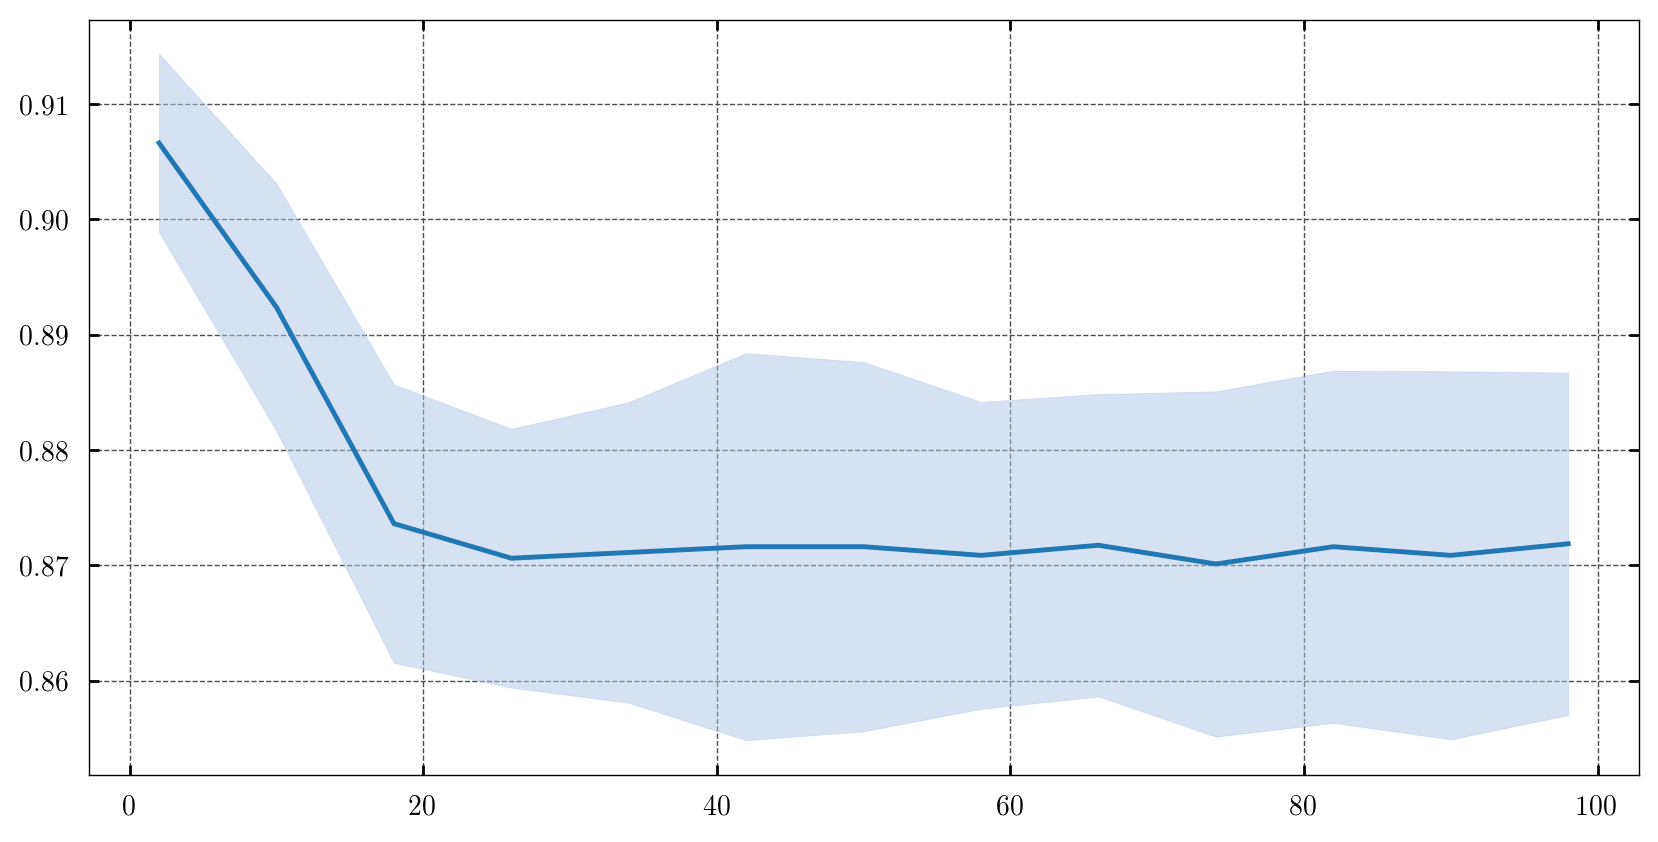

In [33]:
plot_mean = clf.cv_results_['mean_test_score']
plot_std  = clf.cv_results_['std_test_score']
max_depth = np.array( [clf.cv_results_['params'][i]['max_depth'] for i in range(0, len(plot_mean))] )

plt.close()

fig, ax = plt.subplots()

# Regularization C=0.0001
ax.plot( max_depth, plot_mean,
         c=color_palette[0],
         label='$C=0.0001$'
       )
ax.fill_between( max_depth, plot_mean-2.*plot_std, plot_mean+2.*plot_std,
                 color=color_palette[1],
                 alpha=0.5
               )

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()

param_grid = {'min_samples_split':np.linspace(0.01,1.,10)}

clf = GridSearchCV( estimator=dtc,
                    param_grid=param_grid,
                    cv=5,
                    verbose=True
                  )

clf.fit( X_train, y_train )

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    6.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

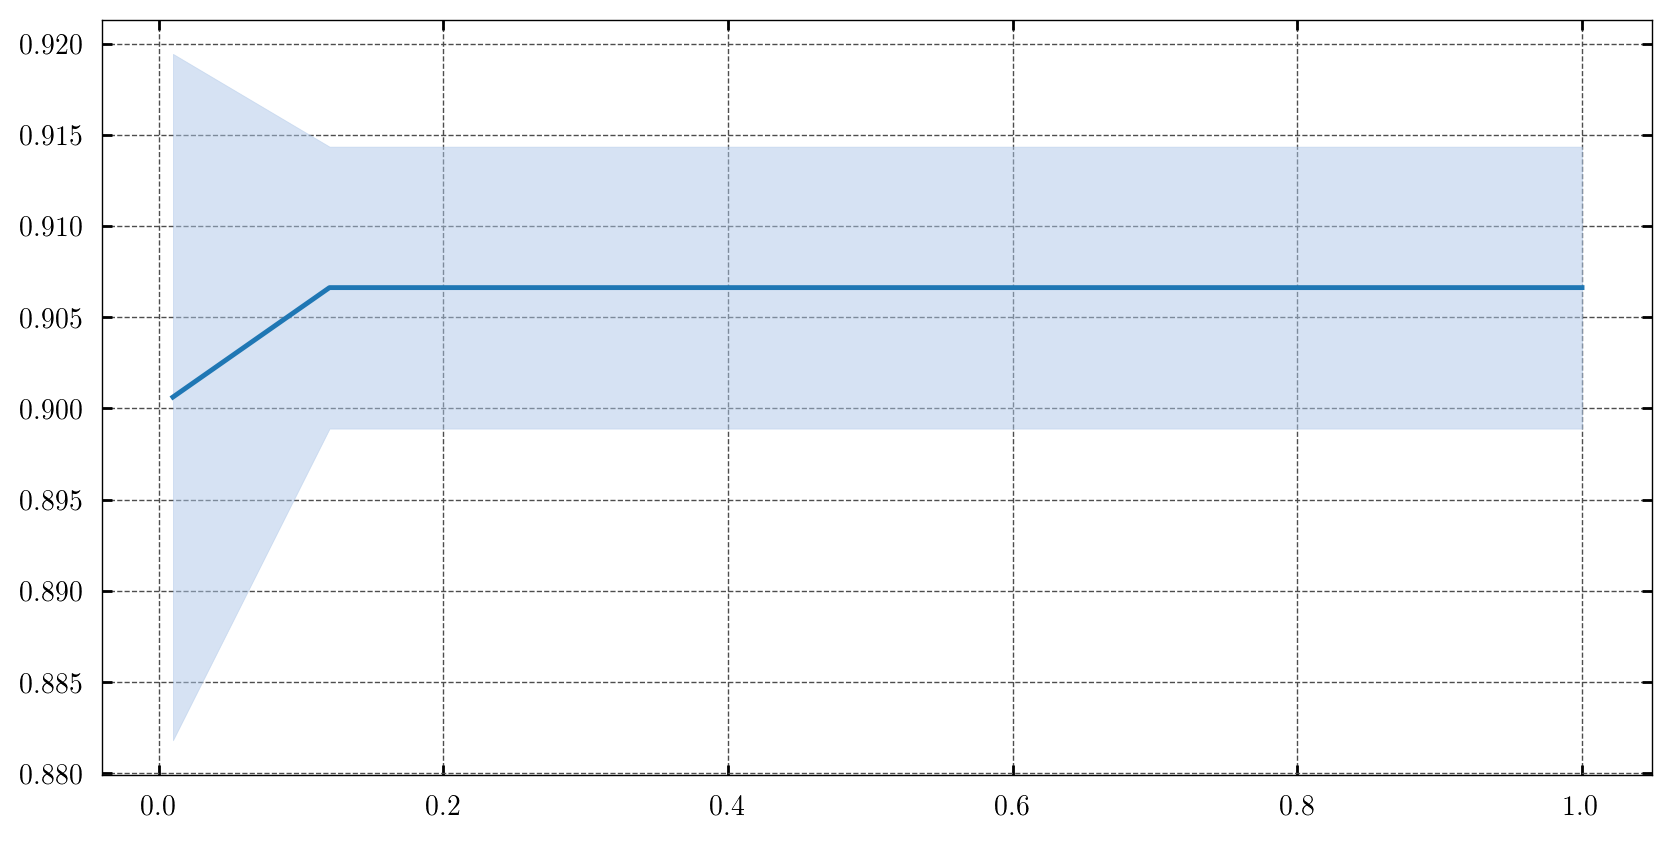

In [36]:
plot_mean = clf.cv_results_['mean_test_score']
plot_std  = clf.cv_results_['std_test_score']
max_depth = np.array( [clf.cv_results_['params'][i]['min_samples_split'] for i in range(0, len(plot_mean))] )

plt.close()

fig, ax = plt.subplots()

# Regularization C=0.0001
ax.plot( max_depth, plot_mean,
         c=color_palette[0],
       )
ax.fill_between( max_depth, plot_mean-2.*plot_std, plot_mean+2.*plot_std,
                 color=color_palette[1],
                 alpha=0.5
               )

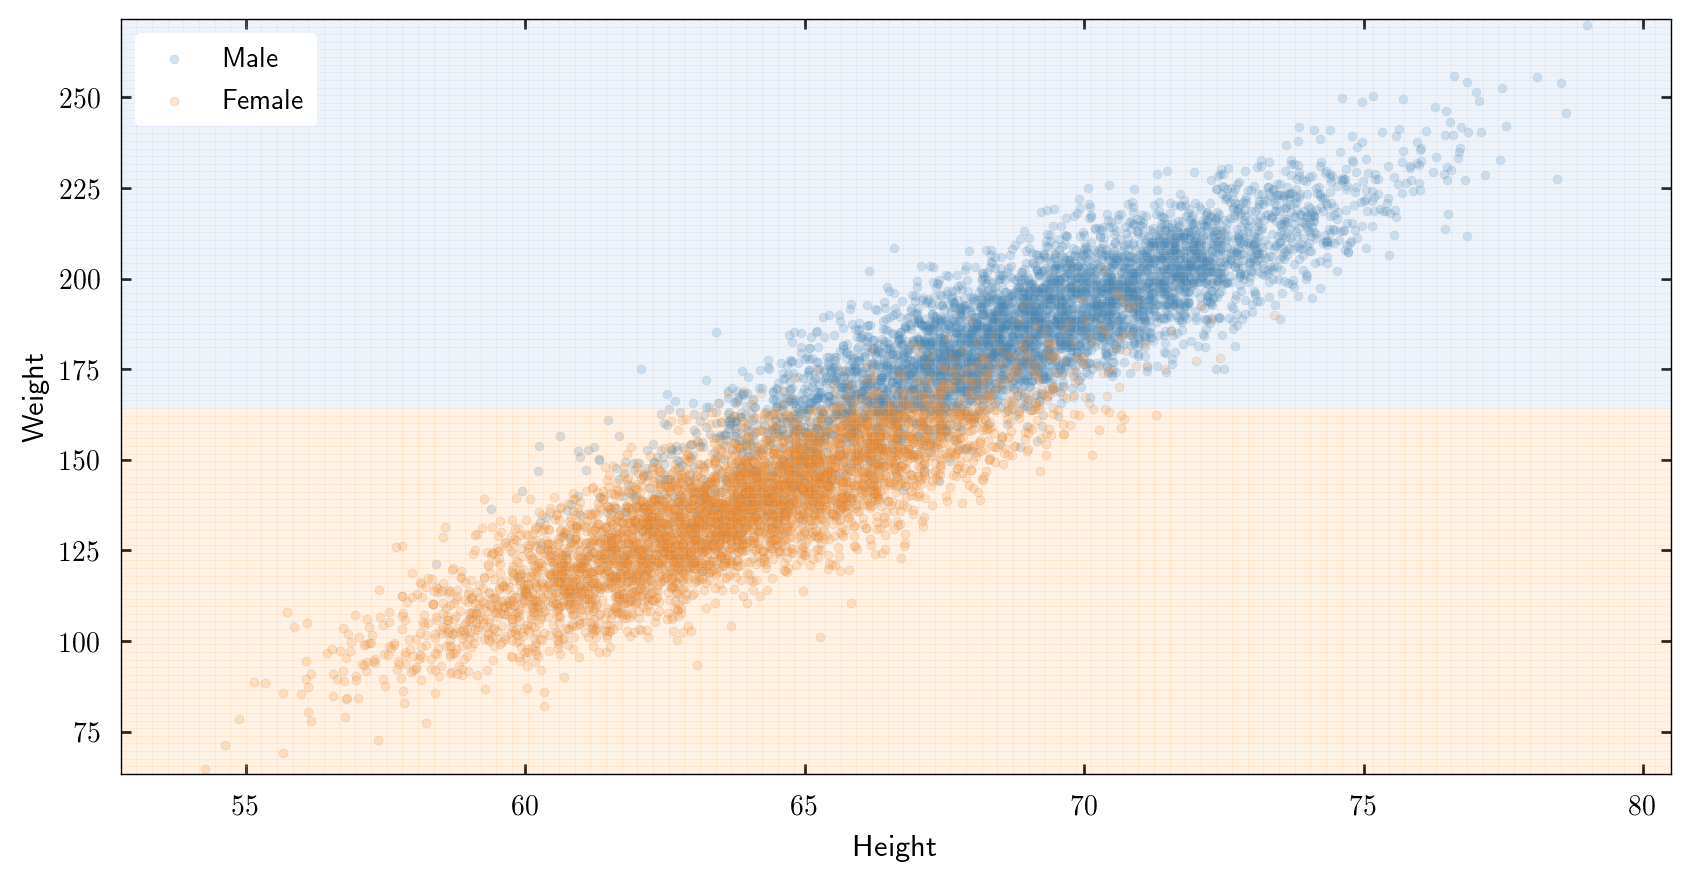

In [38]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier( max_depth=2,
                              min_samples_split=2,
                              min_samples_leaf=1,
                              max_leaf_nodes=None
                            )
dtc.fit( X_train, y_train )

plt.close()

fig, ax = plt.subplots()

plot_decision_boundary( ax, data, dtc )

In [25]:
from sklearn.model_selection import cross_val_score

score = cross_val_score( dtc, X_train, y_train, cv=100 )

(array([ 6., 30., 28., 30.,  6.]),
 array([0.825 , 0.8575, 0.89  , 0.9225, 0.955 , 0.9875]),
 <a list of 5 Patch objects>)

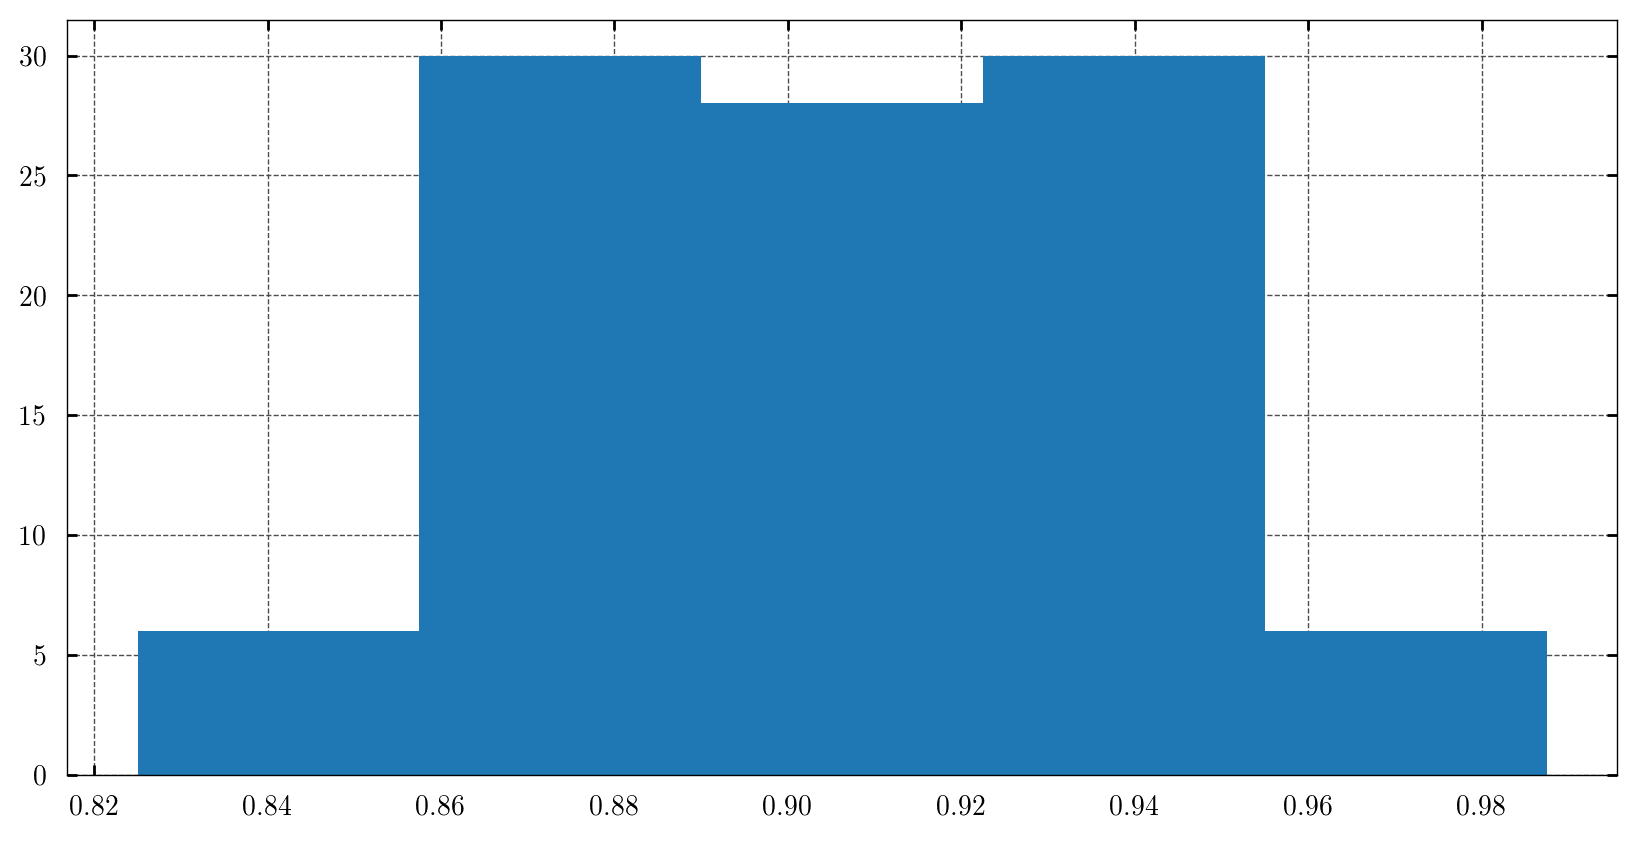

In [26]:
plt.close()

fig, ax = plt.subplots()

ax.hist(score, bins=5)

# 7. Bagging 

In [39]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
bc  = BaggingClassifier( base_estimator=dtc )

param_grid = {'n_estimators':np.arange(1,100,8)}

clf = GridSearchCV( estimator=bc,
                    param_grid=param_grid,
                    cv=5,
                    verbose=True
                  )

clf.fit( X_train, y_train )

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:  2.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            ...n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 1,  9, 17, 25, 33, 41, 49, 57, 65, 73, 81, 89, 97])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

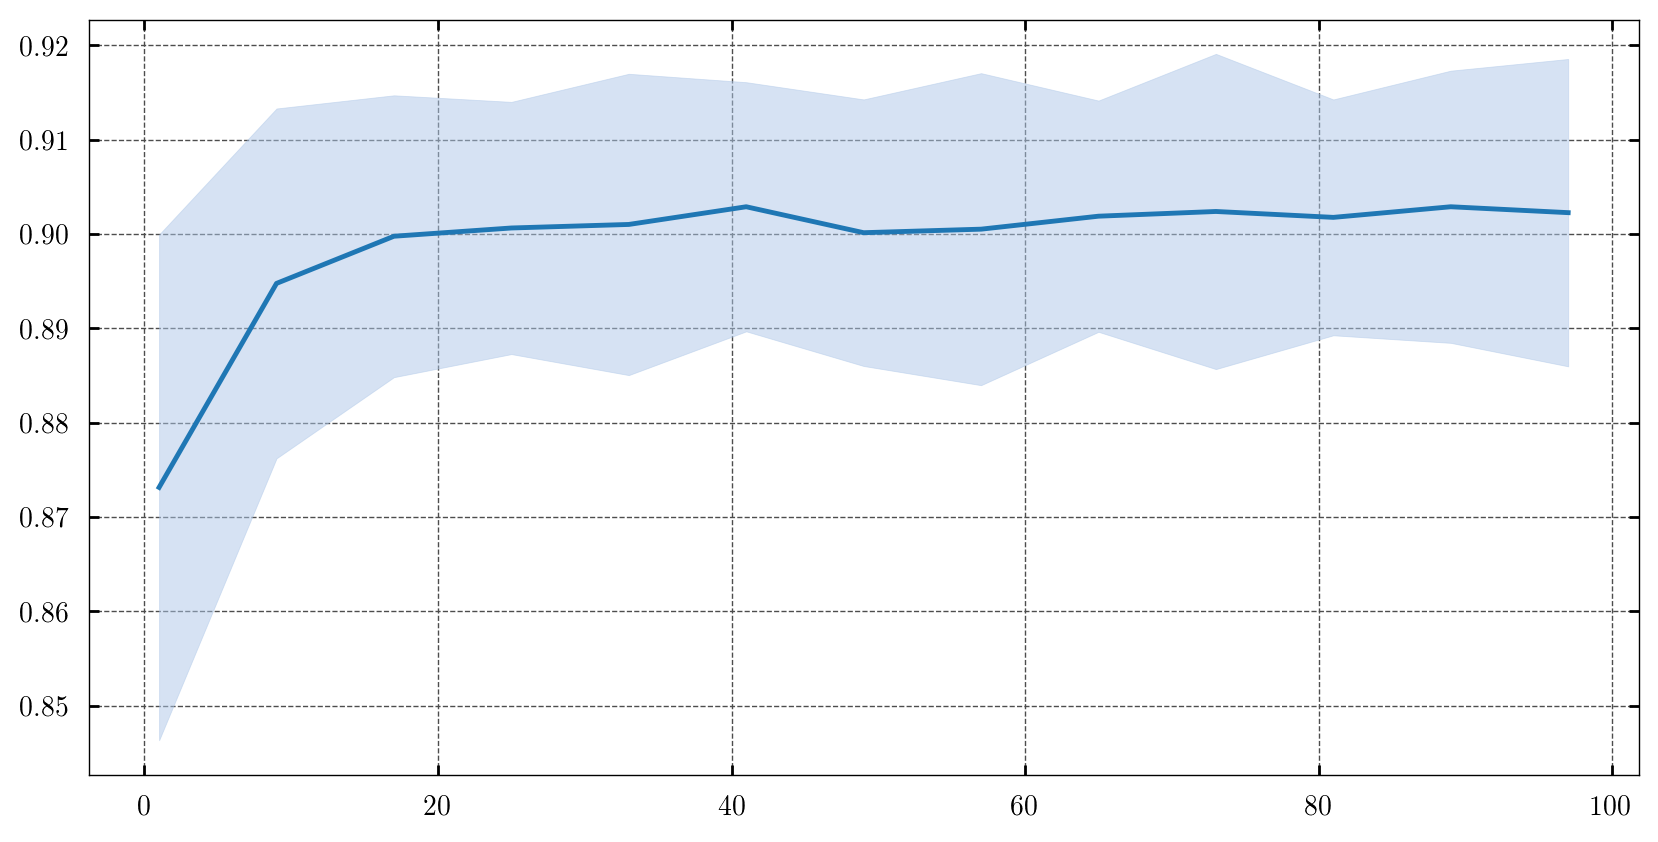

In [41]:
plot_mean = clf.cv_results_['mean_test_score']
plot_std  = clf.cv_results_['std_test_score']
label = np.array( [clf.cv_results_['params'][i]['n_estimators'] for i in range(0, len(plot_mean))] )

plt.close()

fig, ax = plt.subplots()

# Regularization C=0.0001
ax.plot( label, plot_mean,
         c=color_palette[0],
       )
ax.fill_between( label, plot_mean-2.*plot_std, plot_mean+2.*plot_std,
                 color=color_palette[1],
                 alpha=0.5
               )

# 8. RandomForest

In [44]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

param_grid = {'n_estimators':np.arange(1,100,8)}

clf = GridSearchCV( estimator=rfc,
                    param_grid=param_grid,
                    cv=5,
                    verbose=True
                  )

clf.fit( X_train, y_train )

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:  2.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 1,  9, 17, 25, 33, 41, 49, 57, 65, 73, 81, 89, 97])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

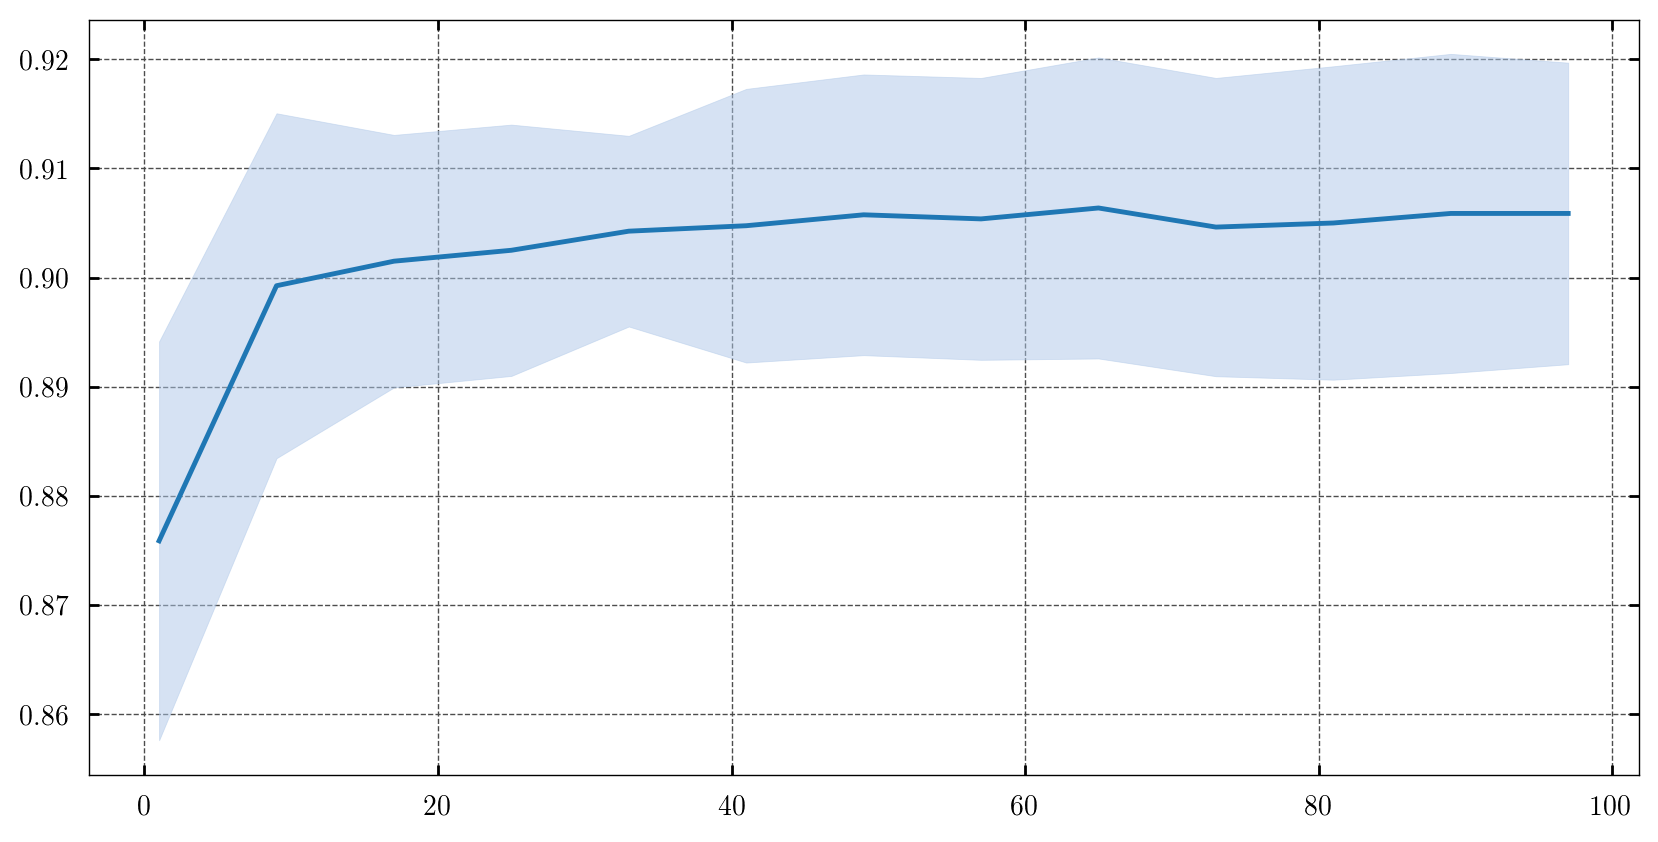

In [45]:
plot_mean = clf.cv_results_['mean_test_score']
plot_std  = clf.cv_results_['std_test_score']
label = np.array( [clf.cv_results_['params'][i]['n_estimators'] for i in range(0, len(plot_mean))] )

plt.close()

fig, ax = plt.subplots()

ax.plot( label, plot_mean,
         c=color_palette[0],
       )
ax.fill_between( label, plot_mean-2.*plot_std, plot_mean+2.*plot_std,
                 color=color_palette[1],
                 alpha=0.5
               )

# 9. Boosting

## 9.1 AdaBoost

## 9.2 GradientBoosting

## 9.3 XGBoost

# 10. Neural Network

In [62]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier( hidden_layer_sizes = (10,10,10) )
mlp.fit( X_train, y_train )

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [63]:
score = cross_val_score( mlp, X_train, y_train, cv=5 )

In [64]:
print( score )

[0.90630856 0.91193004 0.919375   0.92620388 0.9111945 ]


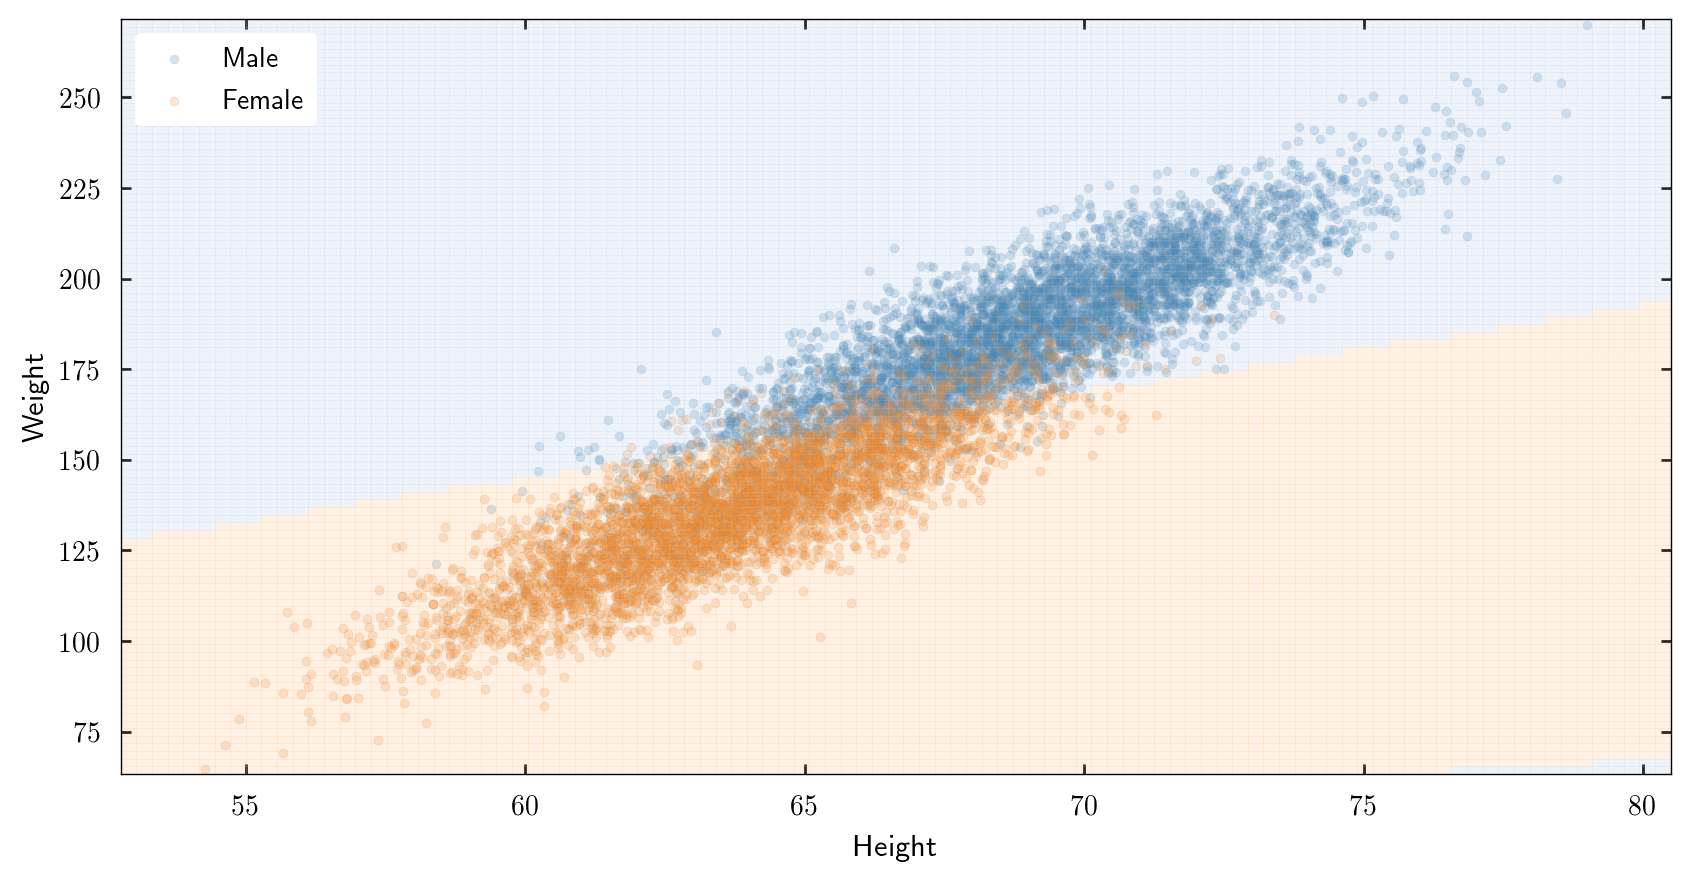

In [65]:
plt.close()

fig, ax = plt.subplots()

plot_decision_boundary( ax, data, mlp )